In [1]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

# Preprocessing

In [41]:
import mne
# cropping the signal before sci calculation
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    # check if coordinates of the channels
    
    
    #print(raw_intensity.ch_names)

    
    # Get event timings
    #print("Extracting event timings...")
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    #print(f"Original duration: {original_duration:.2f} seconds")
    
    # Cropping dataset
    #print("Cropping the dataset...")
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    #print(f"Cropped duration: {cropped_duration:.2f} seconds")
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    

    
    # Remove break annotations
    print("Removing break annotations for the orginal raw...")
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    print("Removing break annotations for the cropped raw...")
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    
    
    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)
    

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    #sci = scalp_coupling_index(raw_od_cropped, h_freq=1.35)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))
    
    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None, None, None, None, None
    
    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels
    
    print(f"Bad channels: {raw_od.info['bads']}")
    # print the number of bad channels
    print(f"Number of bad channels: {len(raw_od.info['bads'])}")
    
    # Remove bad channels
   
    """ raw_od.drop_channels(bad_channels)
    raw_intensity_cropped.drop_channels(bad_channels) """
    
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    
     # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]
    
    """ print(f"Number of all (good and bad) short channels: {tot_number_of_short_channels}")
    print(f"Number of bad long channels: {len(bad_long_chs)}")
    print(f"Number of long and short bad channels: {len(bad_channels)}") """
    # print the number of short bad channels
    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    #print(f"Number of bad short channels: {len_bad_short_chs}")
    
    # Determine if there are short channels
    if  len_bad_short_chs == tot_number_of_short_channels:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None # Keep the data unchanged
    else:
        #print("Applying short-channel regression.")
        raw_od_corrected = short_channel_regression(raw_od)
        #raw_od_corrected=raw_od.copy()
        # drop the bad channels
        #raw_od_corrected.drop_channels(bad_channels)
        
        # interpolate the bad channels
        #raw_od_corrected.interpolate_bads()
        
    # short-channel regression subtracts a scaled version of the signal obtained from the nearest short channel from the signal obtained from the long channel. 

    raw_haemo = beer_lambert_law(raw_od_corrected, ppf=0.1)
    
    #raw_haemo = get_long_channels(raw_haemo, min_dist=0.02, max_dist=0.04) # max_dist 40mm
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.02) 
    
    
   
    

    # Convert to haemoglobin and filter
    
    # check the ppf
    
    #raw_haemo.plot_psd(average=True, show=True)
    
    """ raw_haemo = raw_haemo.filter(
    l_freq=0.01, h_freq=0.7, method="fir", fir_design="firwin", verbose=False,
    h_trans_bandwidth=0.3, l_trans_bandwidth=0.005) """
    
    # improved filter
    """ raw_haemo = raw_haemo.filter(
    l_freq=0.01, h_freq=0.2, method="fir", fir_design="firwin", verbose=False,
    h_trans_bandwidth=0.01, l_trans_bandwidth=0.01) """
    
    #raw_haemo.plot_psd(average=True, show=True)

    raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.2,  
                                 method="iir", iir_params =dict(order=5, ftype='butter'))
     #high-pass
    raw_haemo= raw_haemo.filter(l_freq =  0.005, h_freq = None, method="iir", iir_params =dict(order=5, ftype='butter'))#t0.05 was cutoff in andreas analysis
      
    """ # drop the bad channels
    raw_heamo_good = raw_haemo.copy()
    
    raw_heamo_good.drop_channels(raw_haemo.info['bads']) """
    
    
    #raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=5000,show_scrollbars=True )

    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-5,
        tmax=15,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=None,
    )
    """ epochs['Control'].plot()
    epochs['Noise'].plot()
    epochs['Speech'].plot()
     """


    return raw_haemo, epochs, event_dict, raw_od, events

# Test individual subject

Detected subjects: ['05']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D16 785', 'S6_D16 830', 'S7_D6 785', 'S7_D6 830']
Number of bad channels: 12
Subject 05, Session 01: 60 epochs left
Participant 05, Session 01


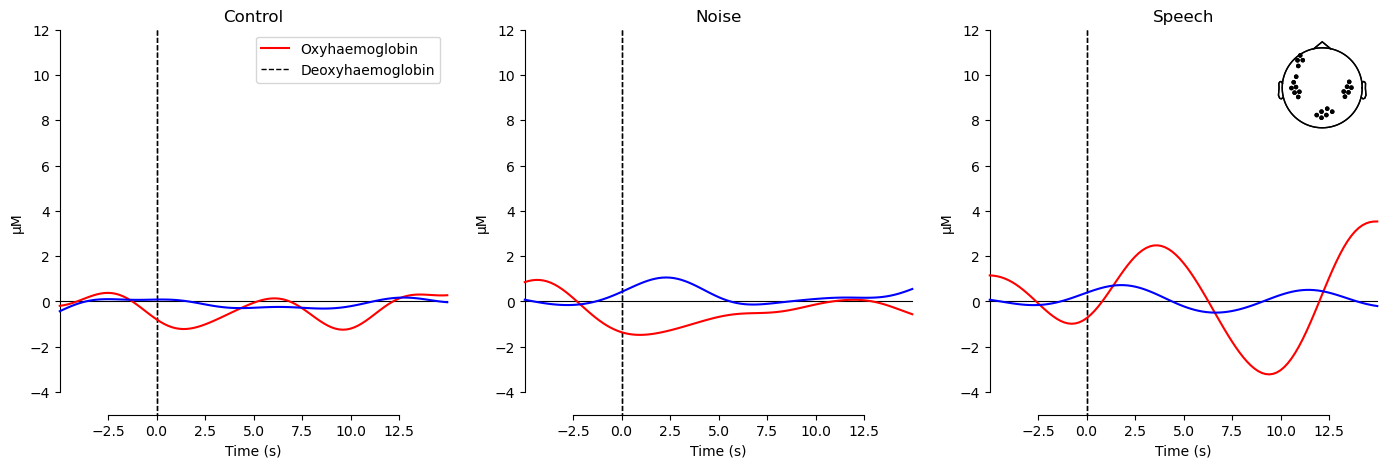

In [38]:
all_evokeds = defaultdict(list)

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers
subject_list = subject_list[4:5]
print("Detected subjects:", subject_list)

# initialize the list of subjects df it has 2 columns, one for subject and one for session
subjects_df = pd.DataFrame(columns=["subject", "session"])

#for sub in range(1,2):  # Loop over subjects
for sub in subject_list:  # Loop over subjects
    for ses in range(1,2):  
        bids_path = BIDSPath(
            #subject=f"{sub:02d}",
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)
        
        if raw_haemo is None:
            print(f"⚠️ Not enough channels left for Subject {sub}, Session {ses:02d}. Skipping...")
            #print(f"⚠️ Not enough channels left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            continue

        # Check if epochs contain data
        #print(f"Subject {sub:02d}, Session {ses:02d}: {len(epochs)} epochs left")
        print(f"Subject {sub}, Session {ses:02d}: {len(epochs)} epochs left")

        if len(epochs) < 10:
            #print(f"⚠️ Not enough epochs left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            print(f"⚠️ Not enough epochs left for Subject {sub}, Session {ses:02d}. Skipping...")
            # plot the raw_haemo data
            #raw_haemo.plot(n_channels=30, duration=300, show=True)
            
            continue  # Skip this subject/session
        
        
                
        # If the subject has not been skipped save in a dataframe the name and session
        subjects_df = pd.concat([subjects_df, pd.DataFrame({"subject": [sub], "session": [ses]})], ignore_index=True)
        
        indiv_evoked = defaultdict(list)
        # For each individual subject, plot the evoked responses
        for condition in epochs.event_id:
            indiv_evoked[condition]= (epochs[condition].average())
        
        fig, axes = plt.subplots(nrows=1, ncols=len(indiv_evoked), figsize=(17, 5))
        lims = dict(hbo=[-5, 12], hbr=[-5, 12])
        
        # print participant number and session
        print(f"Participant {sub}, Session {ses:02d}")

        for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
            for idx, evoked in enumerate(indiv_evoked):
                plot_compare_evokeds(
                    {evoked: indiv_evoked[evoked]},
                    combine="mean",
                    picks=pick,
                    axes=axes[idx],
                    show=False,
                    colors=[color],
                    legend=False,
                    ylim=lims,
                    ci=0.95,
                    show_sensors=idx == 2,
        )
                axes[idx].set_title(f"{evoked}")
        axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])
        
        # show the figure
        plt.show()
        
        
        
        # Save individual-evoked participant data
        for condition in epochs.event_id:
            all_evokeds[condition].append(epochs[condition])
# Save the dataframe to a csv file
subjects_df.to_csv("subjects_df.csv", index=True)


In [30]:
bad_ch= epochs.info['bads']

epochs.drop_channels(bad_ch)




<Epochs | 59 events (all good), -4.992 – 14.976 s (baseline -4.992 – 0 s), ~2.2 MiB, data loaded,
 np.str_('Control'): 20
 np.str_('Noise'): 20
 np.str_('Speech'): 19>

In [31]:
# get only hbo channels data

hbo_data = epochs.copy().pick("hbo")
hbo_data.plot()

In [32]:
data= hbo_data.get_data()
info= hbo_data.info.copy()
data # shape=(60, 50, 90)) 20 cont, 20 noise, 20 speech, 50 channels, 90 time points

array([[[ 9.39945745e-06,  8.36284284e-06,  7.25314776e-06, ...,
          1.80090521e-05,  1.90963010e-05,  2.01821445e-05],
        [ 2.36702324e-07, -5.74729634e-07, -1.36673263e-06, ...,
          3.99117611e-06,  4.04121683e-06,  4.06870326e-06],
        [-3.86868207e-06, -4.81198717e-06, -5.71212447e-06, ...,
         -8.97082585e-07, -1.73014372e-06, -2.59340510e-06],
        ...,
        [ 2.76198453e-06,  2.69008095e-06,  2.52639318e-06, ...,
         -1.36405904e-06, -1.26424201e-06, -1.09548004e-06],
        [ 4.14762196e-06,  3.71684625e-06,  3.23432270e-06, ...,
          5.80665543e-06,  6.63813605e-06,  7.50485100e-06],
        [-3.53451478e-06, -3.10193403e-06, -2.66737820e-06, ...,
         -4.83839516e-06, -4.91580604e-06, -4.90225292e-06]],

       [[-7.85898625e-06, -7.23743371e-06, -6.55913203e-06, ...,
          6.70265190e-06,  6.75358939e-06,  6.78736053e-06],
        [ 9.55392572e-07,  1.00303832e-06,  1.09609090e-06, ...,
         -1.61099105e-06, -2.17265520e

In [550]:
epochs.plot()
#41, 47

In [33]:
# Extract the timepoints between 34 and 45 (inclusive)
time_slice = data[:, :, 44:55]

# Get the max value along the time axis for each condition and channel
max_values = np.max(time_slice, axis=2)
max_values


array([[ 4.27095051e-05,  1.48632680e-05,  5.51815582e-06, ...,
         6.80849560e-06,  9.25057847e-06, -1.14494855e-06],
       [ 9.70261965e-06,  1.44449655e-05,  1.02579834e-05, ...,
         6.08451306e-06,  4.93138152e-06,  4.40189181e-06],
       [ 4.68519347e-06,  2.44800686e-06,  7.37056863e-07, ...,
        -1.06299749e-06,  5.81051914e-06,  3.81718925e-06],
       ...,
       [ 8.15828523e-06,  1.47725708e-06,  5.24353604e-06, ...,
        -1.02707249e-05, -6.52801173e-06, -4.57066380e-06],
       [ 3.86247236e-06,  6.56385926e-06,  7.30183614e-06, ...,
         5.37430443e-06,  1.11247192e-05, -1.62990470e-05],
       [ 3.46306613e-06,  3.79134285e-08,  5.67853022e-06, ...,
        -7.35391510e-07, -6.66309120e-06, -4.23749541e-07]],
      shape=(59, 23))

In [34]:
ev= epochs.events[:, 2]

index_column = np.arange(0, len(ev)).reshape(-1, 1)

updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))
updated_matrix
# For values where the second column is 1
control_mat = updated_matrix[updated_matrix[:, 1] == 1]
control_idx = control_mat[:, 0]


# For values where the second column is 2
noise_mat = updated_matrix[updated_matrix[:, 1] == 2]
noise_idx = noise_mat[:, 0]

# For values where the second column is 3
speech_mat = updated_matrix[updated_matrix[:, 1] == 3]
speech_idx = speech_mat[:, 0]

print((control_idx))
print((noise_idx))
print((speech_idx))


[ 2  3  9 10 11 13 14 16 17 19 24 26 28 29 32 34 51 52 54 56]
[ 4  5  7  8 12 18 20 23 25 33 35 37 38 39 44 47 48 53 55 57]
[ 0  1  6 15 21 22 27 30 31 36 40 41 42 43 45 46 49 50 58]


In [35]:
control_max = max_values[control_idx, :]
noise_max = max_values[noise_idx, :]
speech_max = max_values[speech_idx, :]
speech_max.shape

(19, 23)

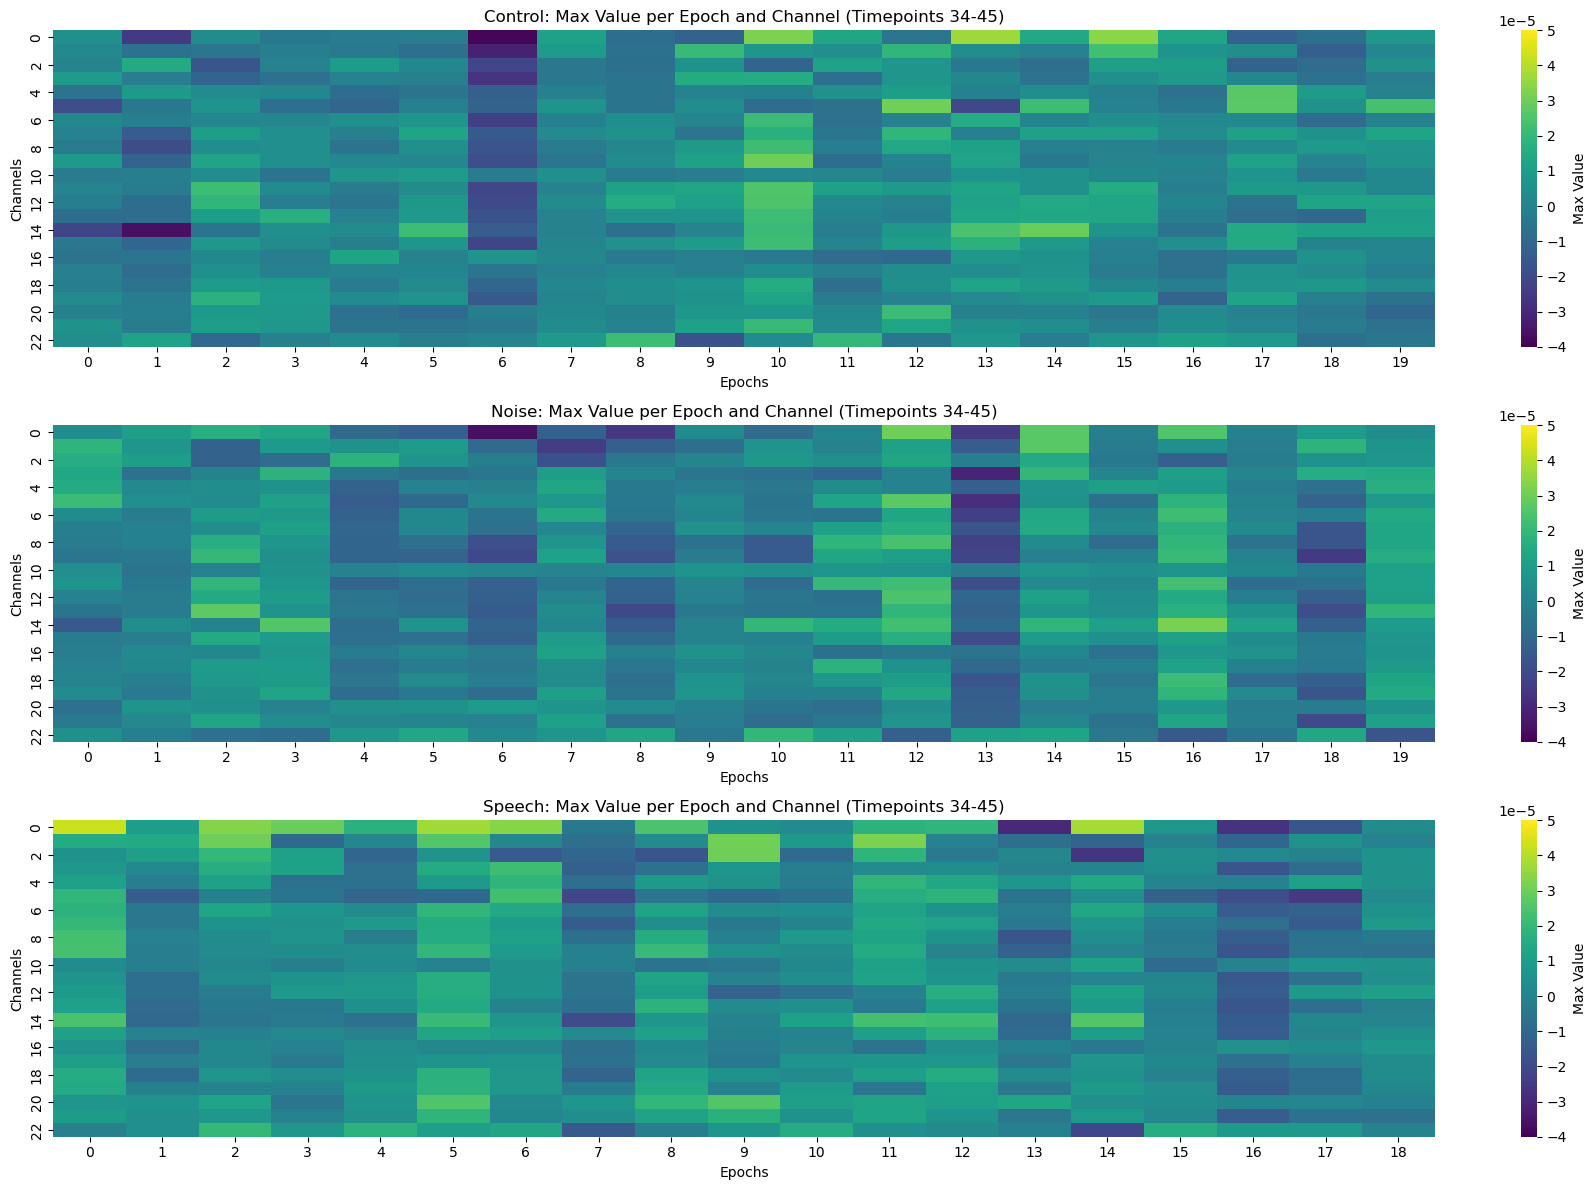

In [36]:
# BEFORE REMOVE OUTLIERS

# Calculate the global min and max values across all three datasets
vmin = -4e-5
vmax = 5e-5

# Plot the heatmaps with the same scale
plt.figure(figsize=(18, 12))

# Control
plt.subplot(3, 1, 1)
sns.heatmap(control_max.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Control: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

# Noise
plt.subplot(3, 1, 2)
sns.heatmap(noise_max.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Noise: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

# Speech
plt.subplot(3, 1, 3)
sns.heatmap(speech_max.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Speech: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

plt.tight_layout()
plt.show()


In [555]:
"""  
def z_score_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    return outlier_indices

# Step 1: Mean per epoch
control_means = control_max.mean(axis=1)
noise_means = noise_max.mean(axis=1)
speech_means = speech_max.mean(axis=1)

# Step 2: Z-score method for outlier detection
control_outlier_indices = z_score_outliers(control_means)
noise_outlier_indices = z_score_outliers(noise_means)
speech_outlier_indices = z_score_outliers(speech_means)

# Step 3: Remove outliers
control_max_cleaned = np.delete(control_max, control_outlier_indices, axis=0)
noise_max_cleaned = np.delete(noise_max, noise_outlier_indices, axis=0)
speech_max_cleaned = np.delete(speech_max, speech_outlier_indices, axis=0)

# Epoch index mapping
removed_control_epochs = control_idx[control_outlier_indices]
removed_noise_epochs = noise_idx[noise_outlier_indices]
removed_speech_epochs = speech_idx[speech_outlier_indices]

(
control_outlier_indices, control_max_cleaned.shape, removed_control_epochs,
noise_outlier_indices, noise_max_cleaned.shape, removed_noise_epochs,
speech_outlier_indices, speech_max_cleaned.shape, removed_speech_epochs
)
  """

'  \ndef z_score_outliers(data, threshold=3):\n    mean = np.mean(data)\n    std = np.std(data)\n    z_scores = (data - mean) / std\n    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]\n    return outlier_indices\n\n# Step 1: Mean per epoch\ncontrol_means = control_max.mean(axis=1)\nnoise_means = noise_max.mean(axis=1)\nspeech_means = speech_max.mean(axis=1)\n\n# Step 2: Z-score method for outlier detection\ncontrol_outlier_indices = z_score_outliers(control_means)\nnoise_outlier_indices = z_score_outliers(noise_means)\nspeech_outlier_indices = z_score_outliers(speech_means)\n\n# Step 3: Remove outliers\ncontrol_max_cleaned = np.delete(control_max, control_outlier_indices, axis=0)\nnoise_max_cleaned = np.delete(noise_max, noise_outlier_indices, axis=0)\nspeech_max_cleaned = np.delete(speech_max, speech_outlier_indices, axis=0)\n\n# Epoch index mapping\nremoved_control_epochs = control_idx[control_outlier_indices]\nremoved_noise_epochs = noise_idx[noise_outlier_indices]\nrem

In [14]:
import numpy as np

def remove_outliers_modified_zscore(matrix, epoch_indices, threshold=3.5):
    medians = np.median(matrix, axis=1)
    mad = np.median(np.abs(medians - np.median(medians)))
    modified_z_scores = 0.6745 * (medians - np.median(medians)) / mad
    outlier_indices = np.where(np.abs(modified_z_scores) > threshold)[0]
    
    # Calculate the mean of non-outlier epochs
    non_outlier_indices = np.setdiff1d(np.arange(matrix.shape[0]), outlier_indices)
    non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)
    
    # Replace outlier epochs with the mean of non-outlier epochs
    matrix[outlier_indices] = non_outlier_mean
    
    removed_epochs = epoch_indices[outlier_indices]
    
    return matrix, outlier_indices, removed_epochs

# Control
control_max_cleaned, control_outlier_indices, removed_control_epochs = remove_outliers_modified_zscore(control_max, control_idx)

# Noise
noise_max_cleaned, noise_outlier_indices, removed_noise_epochs = remove_outliers_modified_zscore(noise_max, noise_idx)

# Speech
speech_max_cleaned, speech_outlier_indices, removed_speech_epochs = remove_outliers_modified_zscore(speech_max, speech_idx)

# Optionally print results
print(f"Control - Removed {len(control_outlier_indices)} outlier(s):", removed_control_epochs)
print(f"Noise   - Removed {len(noise_outlier_indices)} outlier(s):", removed_noise_epochs)
print(f"Speech  - Removed {len(speech_outlier_indices)} outlier(s):", removed_speech_epochs)


Control - Removed 1 outlier(s): [14]
Noise   - Removed 0 outlier(s): []
Speech  - Removed 0 outlier(s): []


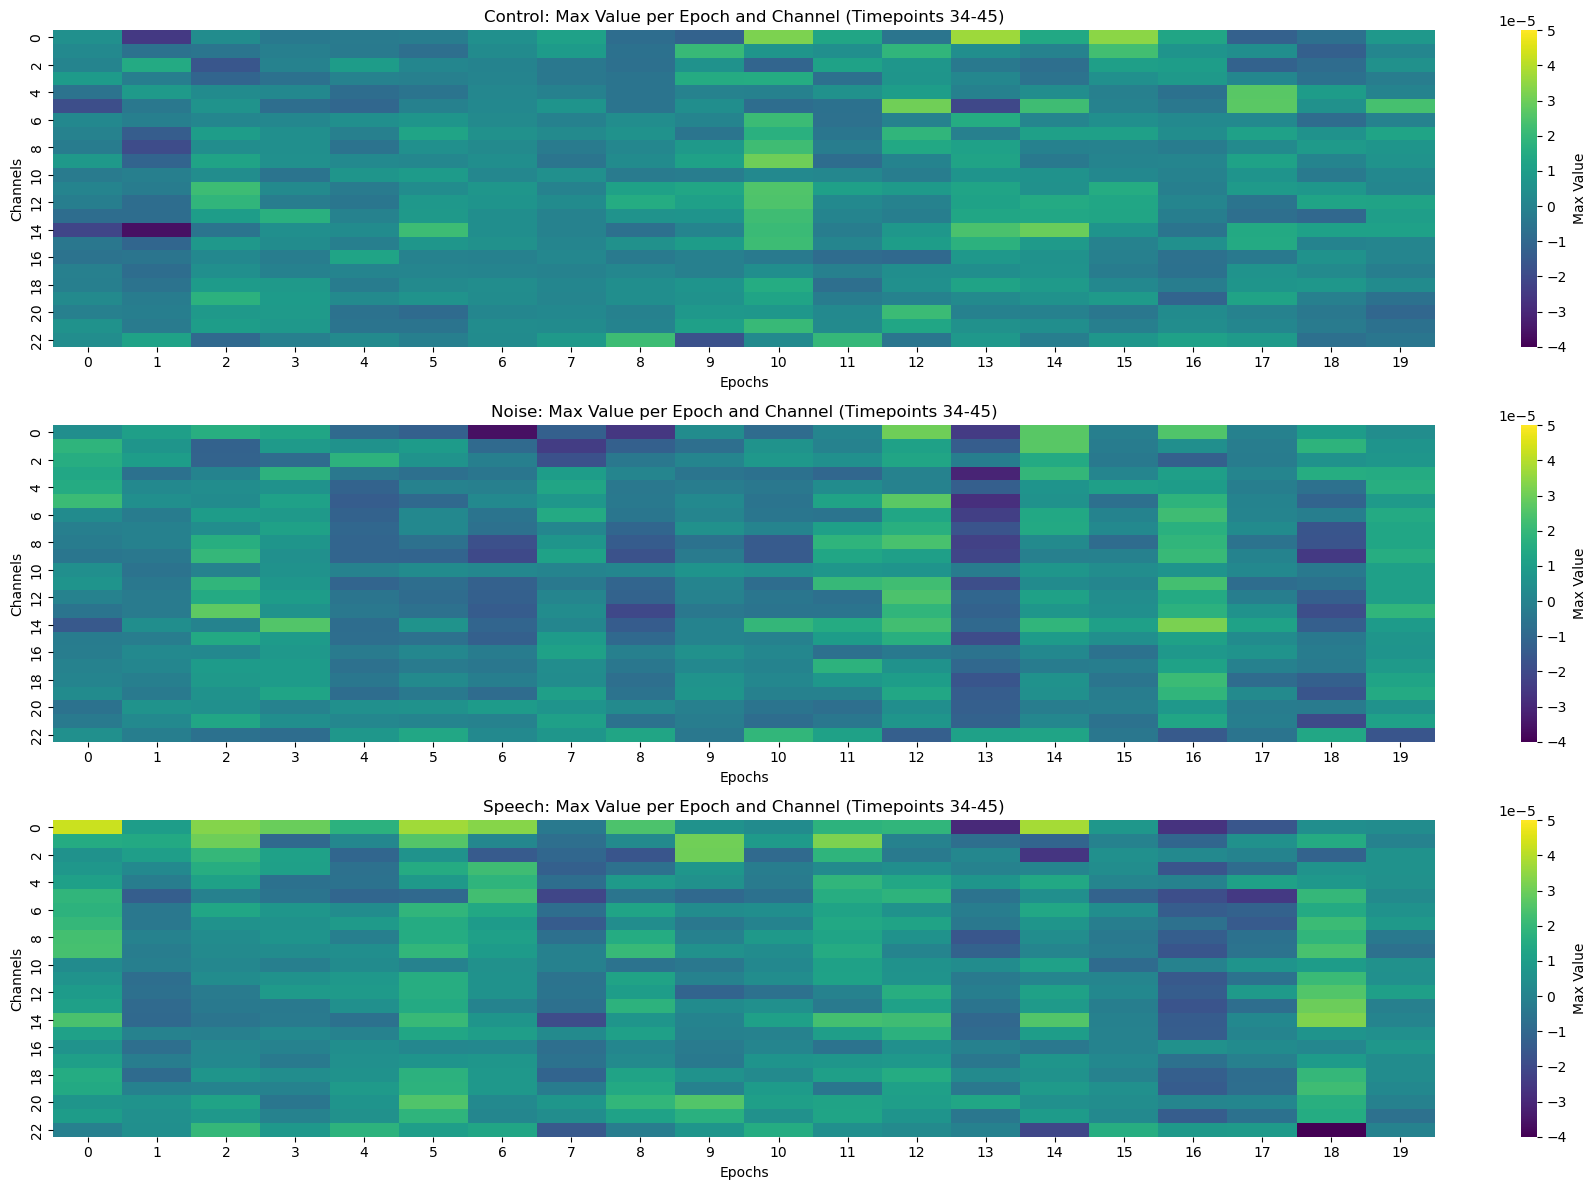

In [16]:
# AFTER OUTLIER REMOVAL
# Assuming control_max_cleaned, noise_max_cleaned, and speech_max_cleaned are your data arrays

# Calculate the global min and max values across all three datasets
vmin = -4e-5
vmax = 5e-5

# Plot the heatmaps with the same scale
plt.figure(figsize=(18, 12))

# Control
plt.subplot(3, 1, 1)
sns.heatmap(control_max_cleaned.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Control: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

# Noise
plt.subplot(3, 1, 2)
sns.heatmap(noise_max_cleaned.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Noise: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

# Speech
plt.subplot(3, 1, 3)
sns.heatmap(speech_max_cleaned.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=vmin, vmax=vmax)
plt.title('Speech: Max Value per Epoch and Channel (Timepoints 34-45)')
plt.xlabel('Epochs')
plt.ylabel('Channels')

plt.tight_layout()
plt.show()


In [558]:
""" import numpy as np

def replace_manual_outliers(matrix, outlier_indices):
    
    # Convert to numpy array in case it's not
    matrix = np.array(matrix)

    all_indices = np.arange(matrix.shape[0])
    non_outlier_indices = np.setdiff1d(all_indices, outlier_indices)
    
    if len(non_outlier_indices) == 0:
        raise ValueError("All epochs are marked as outliers. Cannot compute mean.")

    non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)
    
    # Replace each outlier row with the mean
    matrix[outlier_indices] = non_outlier_mean

    return matrix

# Example: Manually specify outlier epochs
control_outliers_manual = [2, 3, 13]      # Replace epochs 2 and 5 in control
noise_outliers_manual = [ 3]     # Replace epochs 1, 3, 4 in noise
speech_outliers_manual = [4, 6, 19]       # Replace epochs 0 and 6 in speech

# Replace them
control_max_cleaned = replace_manual_outliers(control_max_cleaned, control_outliers_manual)
noise_max_cleaned = replace_manual_outliers(noise_max_cleaned, noise_outliers_manual)
speech_max_cleaned = replace_manual_outliers(speech_max_cleaned, speech_outliers_manual)
 """

' import numpy as np\n\ndef replace_manual_outliers(matrix, outlier_indices):\n    \n    # Convert to numpy array in case it\'s not\n    matrix = np.array(matrix)\n\n    all_indices = np.arange(matrix.shape[0])\n    non_outlier_indices = np.setdiff1d(all_indices, outlier_indices)\n    \n    if len(non_outlier_indices) == 0:\n        raise ValueError("All epochs are marked as outliers. Cannot compute mean.")\n\n    non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)\n    \n    # Replace each outlier row with the mean\n    matrix[outlier_indices] = non_outlier_mean\n\n    return matrix\n\n# Example: Manually specify outlier epochs\ncontrol_outliers_manual = [2, 3, 13]      # Replace epochs 2 and 5 in control\nnoise_outliers_manual = [ 3]     # Replace epochs 1, 3, 4 in noise\nspeech_outliers_manual = [4, 6, 19]       # Replace epochs 0 and 6 in speech\n\n# Replace them\ncontrol_max_cleaned = replace_manual_outliers(control_max_cleaned, control_outliers_manual)\nnoise_max_clea

In [559]:
from scipy.stats import ttest_rel

""" control_max_cleaned = control_max.copy()
noise_max_cleaned = noise_max.copy()
speech_max_cleaned = speech_max.copy() """

# Ensure same number of epochs across conditions
min_epochs = min(control_max_cleaned.shape[0], noise_max_cleaned.shape[0], speech_max_cleaned.shape[0])

# Trim all matrices to the same number of epochs
control_trimmed = control_max_cleaned[:min_epochs, :]
noise_trimmed = noise_max_cleaned[:min_epochs, :]
speech_trimmed = speech_max_cleaned[:min_epochs, :]

# Perform paired t-tests
p_values_control_vs_noise = []
p_values_control_vs_speech = []

for channel in range(control_trimmed.shape[1]):
    t_stat_cn, p_cn = ttest_rel(control_trimmed[:, channel], noise_trimmed[:, channel])
    t_stat_cs, p_cs = ttest_rel(control_trimmed[:, channel], speech_trimmed[:, channel])
    
    p_values_control_vs_noise.append(p_cn)
    p_values_control_vs_speech.append(p_cs)

# Optionally, convert to numpy arrays
p_values_control_vs_noise = np.array(p_values_control_vs_noise)
p_values_control_vs_speech = np.array(p_values_control_vs_speech)

# You could also apply multiple comparisons correction here (e.g., Bonferroni or FDR)
print(p_values_control_vs_noise)
print(p_values_control_vs_speech)


[3.97258400e-01 7.31333518e-01 4.60066993e-01 2.78748689e-01
 4.11871239e-01 8.07543100e-01 3.43465441e-03 5.40930967e-04
 4.09724143e-02 9.35374837e-02 1.03916201e-01 6.91188597e-02
 1.00861096e-01 1.27733226e-01 2.61288671e-01 5.48439731e-04
 4.58835117e-03 4.87805138e-02 3.57861645e-02 7.44649683e-01]
[2.13644229e-02 9.59399564e-02 1.11340213e-01 1.08597574e-02
 2.57259016e-01 6.43251721e-01 1.80671400e-02 2.27815820e-03
 4.89137357e-03 3.47247731e-02 3.03808982e-03 4.07195402e-02
 2.94913815e-01 7.26621416e-02 2.17990633e-02 5.89063057e-04
 1.52291885e-02 1.07921875e-02 2.05249205e-02 4.02118994e-02]


In [560]:

# Get indices of the 5 smallest p-values (most significant) for control vs noise
top_5_cn_indices = np.argsort(p_values_control_vs_noise)[:5]
top_5_cs_indices = np.argsort(p_values_control_vs_speech)[:5]

print("Top 5 channels for Control vs Noise:")
for idx in top_5_cn_indices:
    print(f"Channel: {idx}, p-value: {p_values_control_vs_noise[idx]}")

print("\nTop 5 channels for Control vs Speech:")
for idx in top_5_cs_indices:
    print(f"Channel: {idx}, p-value: {p_values_control_vs_speech[idx]}")


Top 5 channels for Control vs Noise:
Channel: 7, p-value: 0.0005409309670741582
Channel: 15, p-value: 0.000548439731473432
Channel: 6, p-value: 0.003434654405648661
Channel: 16, p-value: 0.0045883511662834055
Channel: 18, p-value: 0.03578616445686203

Top 5 channels for Control vs Speech:
Channel: 15, p-value: 0.0005890630568379732
Channel: 7, p-value: 0.002278158198766011
Channel: 10, p-value: 0.003038089819673483
Channel: 8, p-value: 0.004891373566982215
Channel: 17, p-value: 0.010792187542110834


In [561]:
chanels_names= hbo_data.info['ch_names']

# Find indices of significant channels
significant_cn_indices = np.where(p_values_control_vs_noise < 0.05)[0]
significant_cs_indices = np.where(p_values_control_vs_speech < 0.05)[0]

# Sort the significant ones by their p-values
sorted_significant_cn = significant_cn_indices[np.argsort(p_values_control_vs_noise[significant_cn_indices])]
sorted_significant_cs = significant_cs_indices[np.argsort(p_values_control_vs_speech[significant_cs_indices])]

# Print results
print("Significant Channels for Control vs Noise (p < 0.05):")
for idx in sorted_significant_cn:
    print(f"Channel: {chanels_names[idx]}")

print("\nSignificant Channels for Control vs Speech (p < 0.05):")
for idx in sorted_significant_cs:
    print(f"Channel: {chanels_names[idx]}")


Significant Channels for Control vs Noise (p < 0.05):
Channel: S5_D3 hbo
Channel: S10_D11 hbo
Channel: S5_D2 hbo
Channel: S10_D12 hbo
Channel: S11_D12 hbo
Channel: S5_D4 hbo
Channel: S11_D11 hbo

Significant Channels for Control vs Speech (p < 0.05):
Channel: S10_D11 hbo
Channel: S5_D3 hbo
Channel: S7_D7 hbo
Channel: S5_D4 hbo
Channel: S11_D11 hbo
Channel: S3_D2 hbo
Channel: S10_D12 hbo
Channel: S5_D2 hbo
Channel: S11_D12 hbo
Channel: S1_D1 hbo
Channel: S10_D10 hbo
Channel: S5_D5 hbo
Channel: S12_D1 hbo
Channel: S8_D7 hbo


# All together

Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 4
Subject 01, Session 01: 60 epochs left
✅ sub-01 ses-01: 9 CN sig, 22 CS sig; Control epochs removed: 1; Noise epochs removed: 0; Speech epochs removed: 0
Participant 01, Session 01


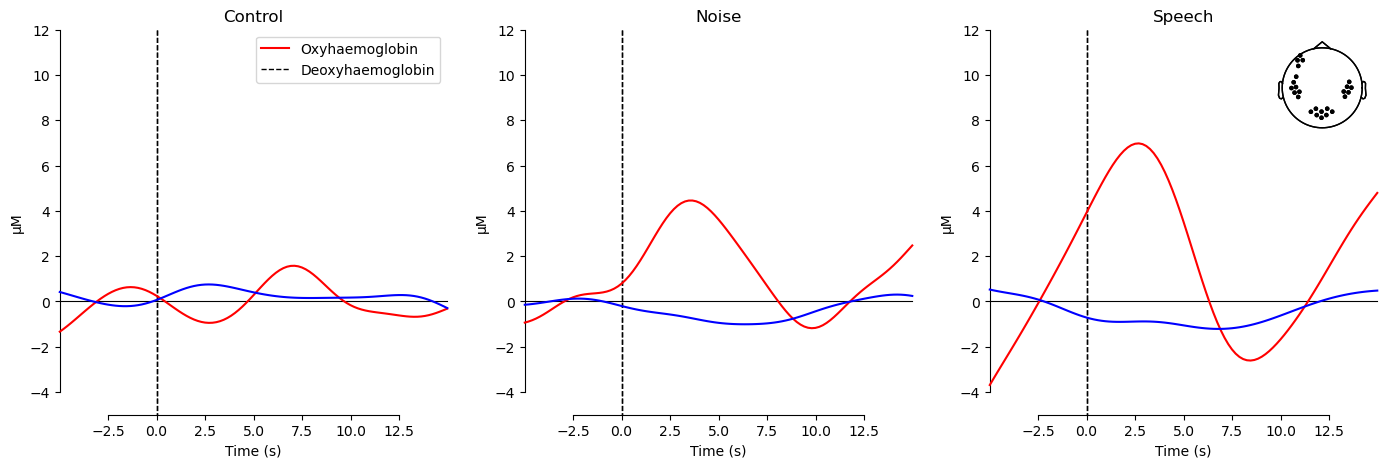

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S8_D17 785', 'S8_D17 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 4
Subject 01, Session 02: 60 epochs left
✅ sub-01 ses-02: 6 CN sig, 12 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 1
Participant 01, Session 02


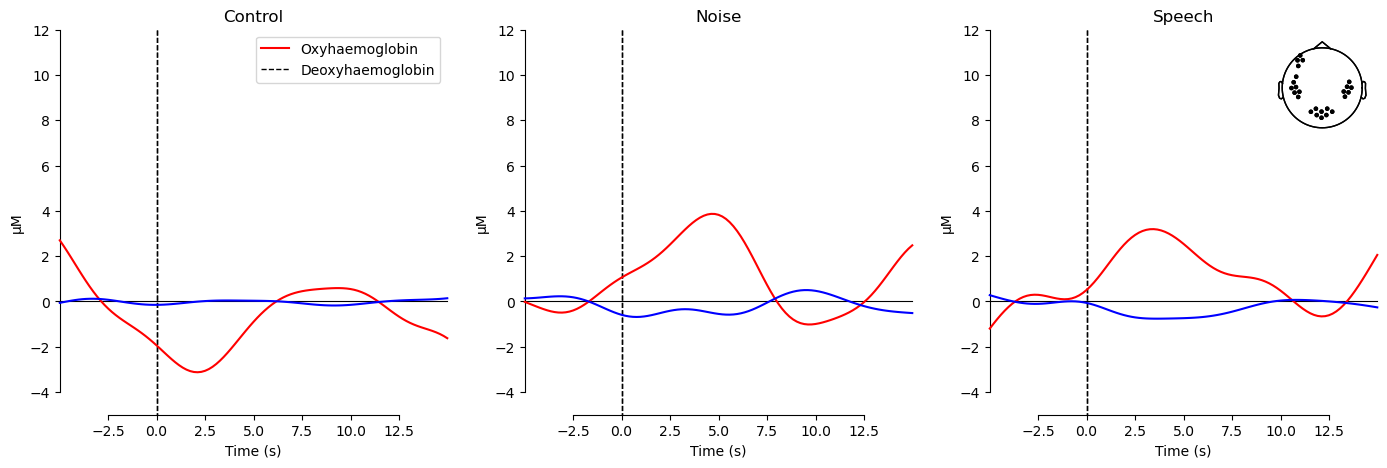

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 4
Subject 02, Session 01: 60 epochs left
✅ sub-02 ses-01: 3 CN sig, 1 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 02, Session 01


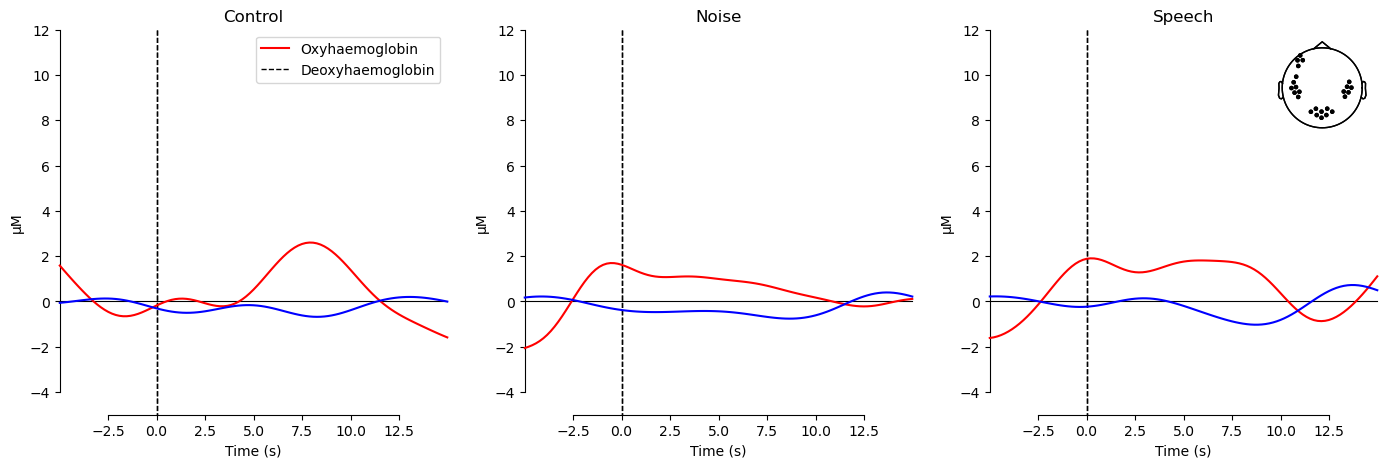

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 4
Subject 02, Session 02: 60 epochs left
✅ sub-02 ses-02: 5 CN sig, 6 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 02, Session 02


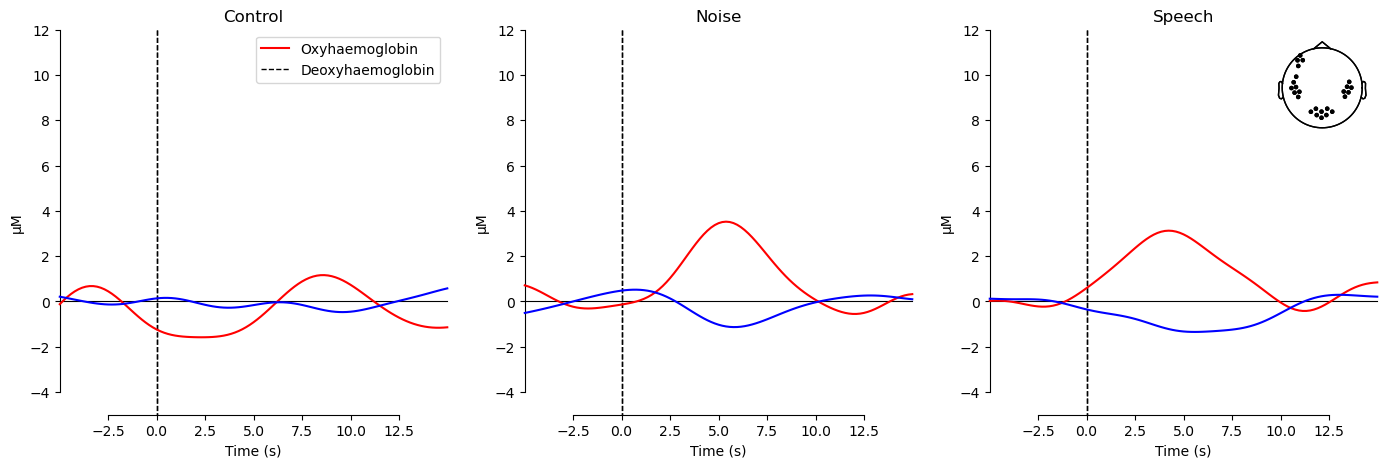

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S6_D16 785', 'S6_D16 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 8
Subject 03, Session 01: 59 epochs left
⚠️ Not enough epochs left for Subject 03, Session 01. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S8_D8 785', 'S8_D8 830', 'S8_D17 785', 'S8_D17 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 6
Subject 03, Session 02: 60 epochs left
✅ sub-03 ses-02: 6 CN sig, 2 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 2
Participant 03, Session 02


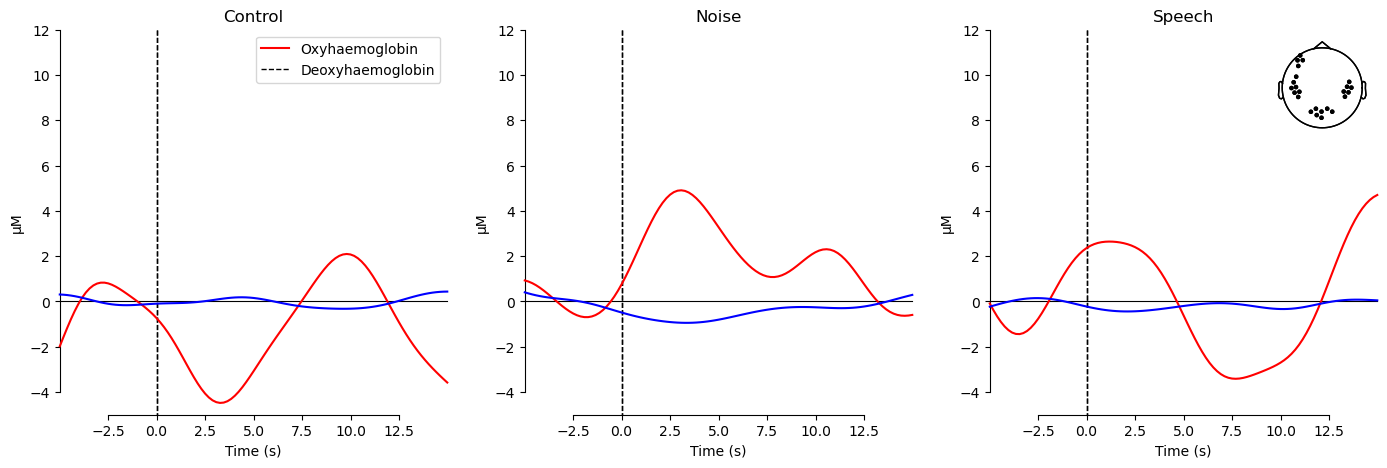

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D16 785', 'S6_D16 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830']
Number of bad channels: 6
Subject 04, Session 01: 60 epochs left
✅ sub-04 ses-01: 0 CN sig, 3 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 1
Participant 04, Session 01


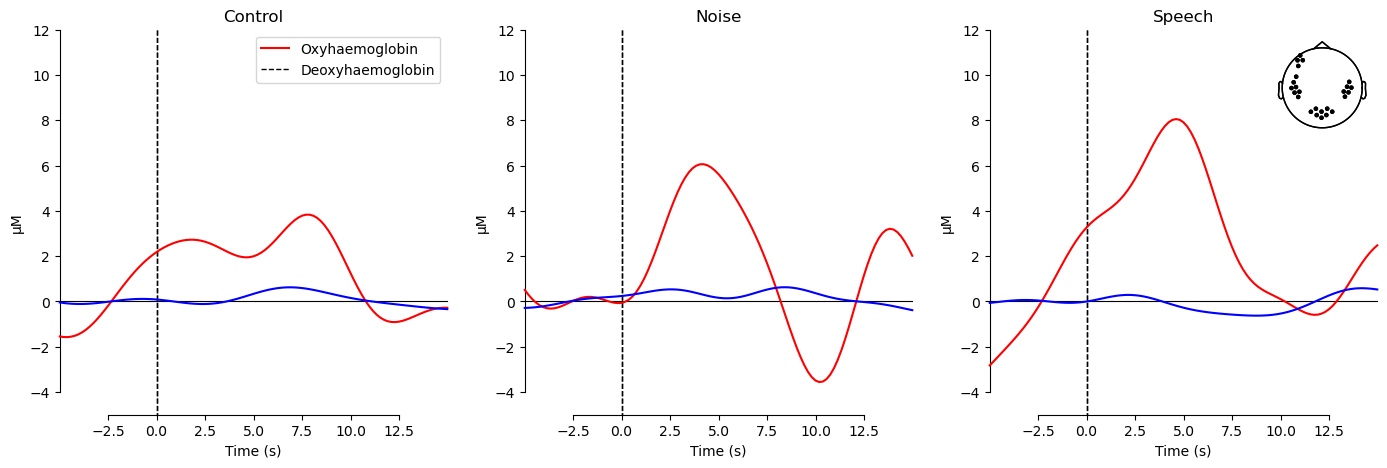

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D16 785', 'S6_D16 830', 'S10_D18 785', 'S10_D18 830']
Number of bad channels: 4
Subject 04, Session 02: 60 epochs left
✅ sub-04 ses-02: 23 CN sig, 22 CS sig; Control epochs removed: 1; Noise epochs removed: 1; Speech epochs removed: 0
Participant 04, Session 02


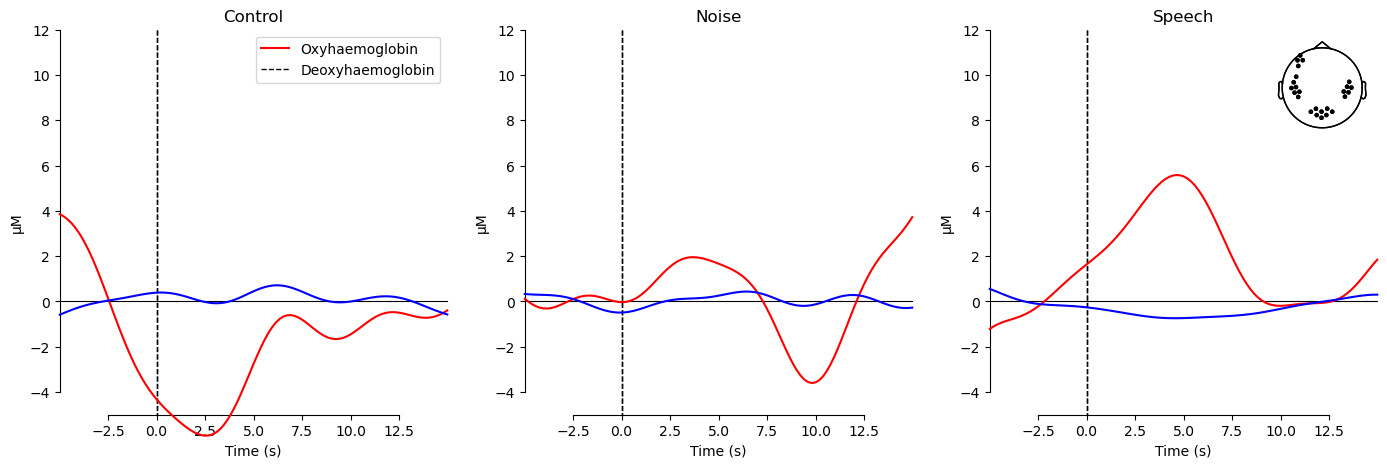

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D16 785', 'S6_D16 830']
Number of bad channels: 8
Subject 05, Session 01: 60 epochs left
✅ sub-05 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 05, Session 01


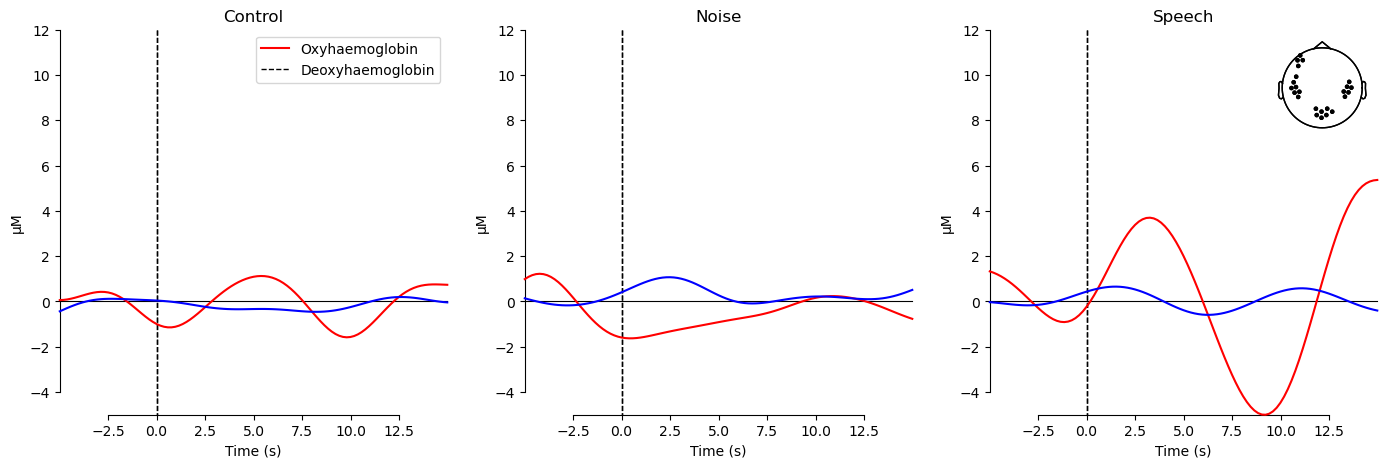

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830']
Number of bad channels: 4
Subject 05, Session 02: 47 epochs left
⚠️ Not enough epochs left for Subject 05, Session 02. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D2 785', 'S4_D2 830', 'S4_D14 785', 'S4_D14 830', 'S6_D16 785', 'S6_D16 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830']
Number of bad channels: 10
Subject 06, Session 01: 59 epochs left
⚠️ Not enough epochs left for Subject 06, Session 01. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D2 785', 'S4_D2 830', 'S4_D3 785', 'S4_D3 830', 'S4_D14 785', 'S4_D14 830', 'S6_D16 785', 'S6_D16 830', 'S9_D8 785', 'S9_D8 830', 'S10_D18 785', 'S10_D18 830']
Number of bad channels: 12
Subje

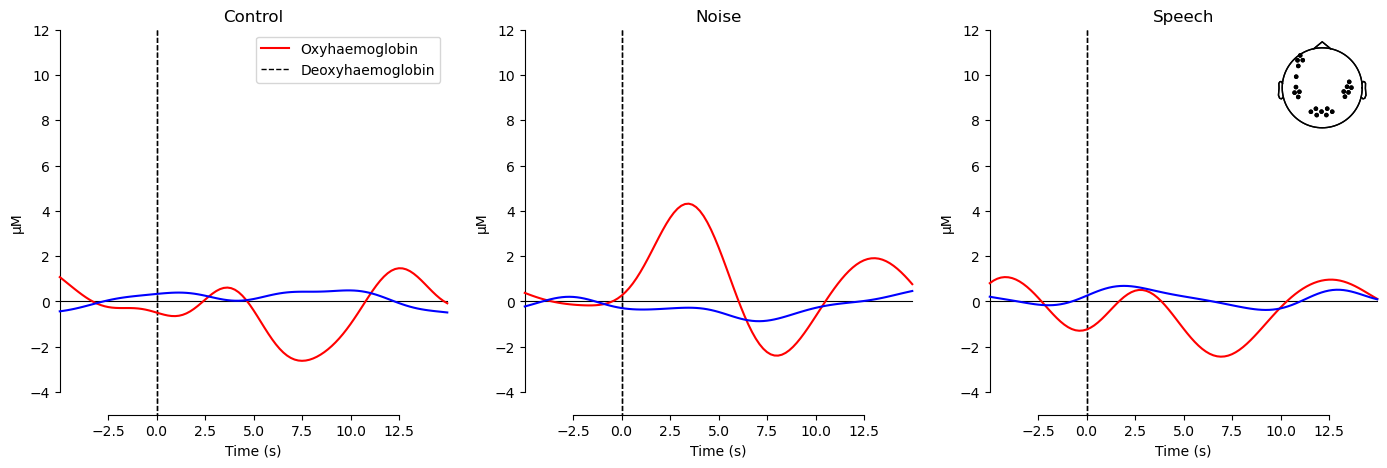

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D16 785', 'S6_D16 830']
Number of bad channels: 8
Subject 07, Session 01: 60 epochs left
✅ sub-07 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 07, Session 01


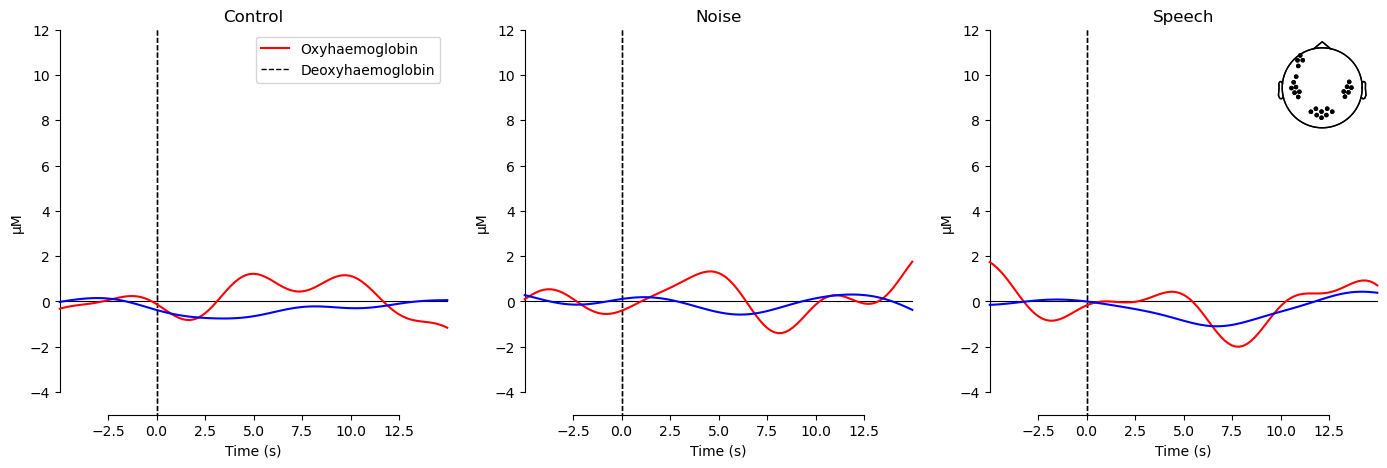

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D16 785', 'S6_D16 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 10
Subject 07, Session 02: 60 epochs left
✅ sub-07 ses-02: 6 CN sig, 4 CS sig; Control epochs removed: 1; Noise epochs removed: 0; Speech epochs removed: 0
Participant 07, Session 02


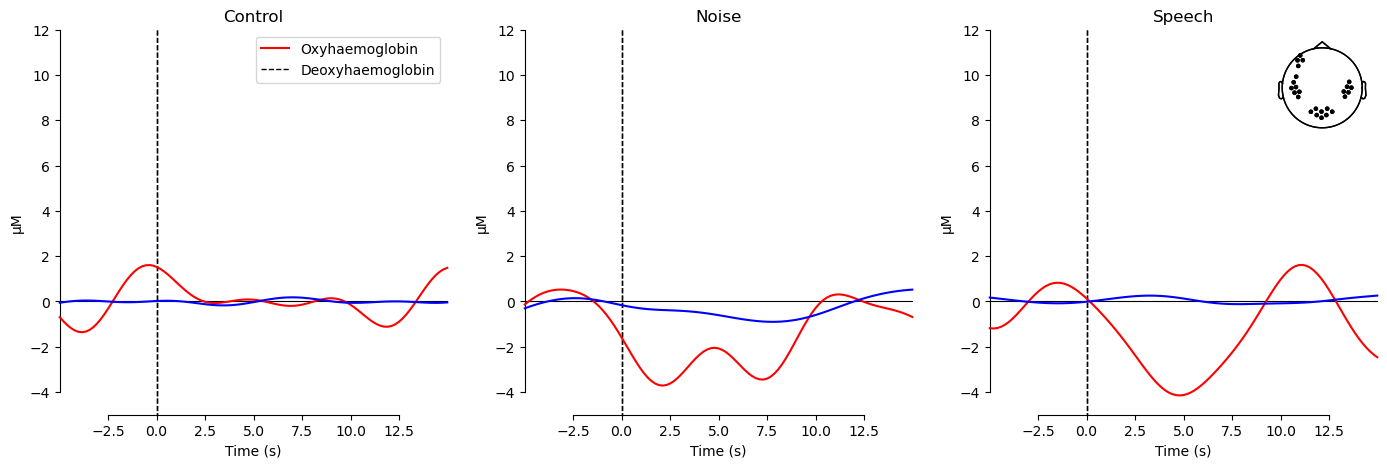

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D16 785', 'S6_D16 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 6
Subject 08, Session 01: 59 epochs left
⚠️ Not enough epochs left for Subject 08, Session 01. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D16 785', 'S6_D16 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 6
Subject 08, Session 02: 60 epochs left
✅ sub-08 ses-02: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 08, Session 02


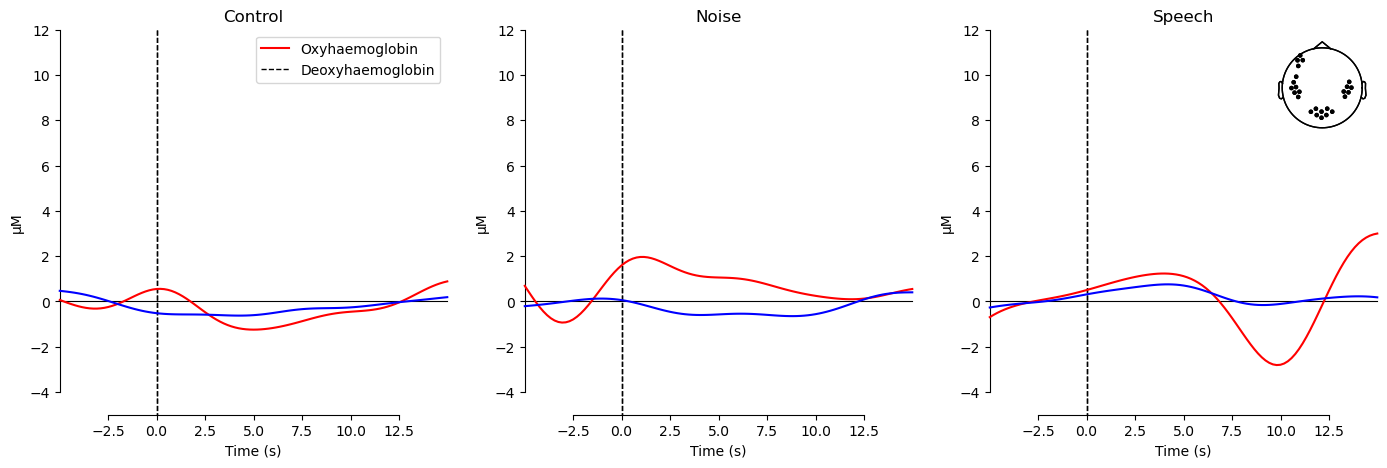

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S3_D2 785', 'S3_D2 830', 'S4_D2 785', 'S4_D2 830', 'S4_D3 785', 'S4_D3 830', 'S4_D14 785', 'S4_D14 830', 'S5_D2 785', 'S5_D2 830', 'S5_D3 785', 'S5_D3 830', 'S5_D4 785', 'S5_D4 830', 'S5_D5 785', 'S5_D5 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D8 785', 'S6_D8 830', 'S7_D6 785', 'S7_D6 830', 'S7_D7 785', 'S7_D7 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S8_D8 785', 'S8_D8 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830', 'S10_D9 785', 'S10_D9 830', 'S10_D10 785', 'S10_D10 830', 'S10_D11 785', 'S10_D11 830', 'S10_D18 785', 'S10_D18 830', 'S11_D11 785', 'S11_D11 830', 'S11_D19 785', 'S11_D19 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 52
Subject 09, Session 01: 60 epochs left
✅ sub-09 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs remove

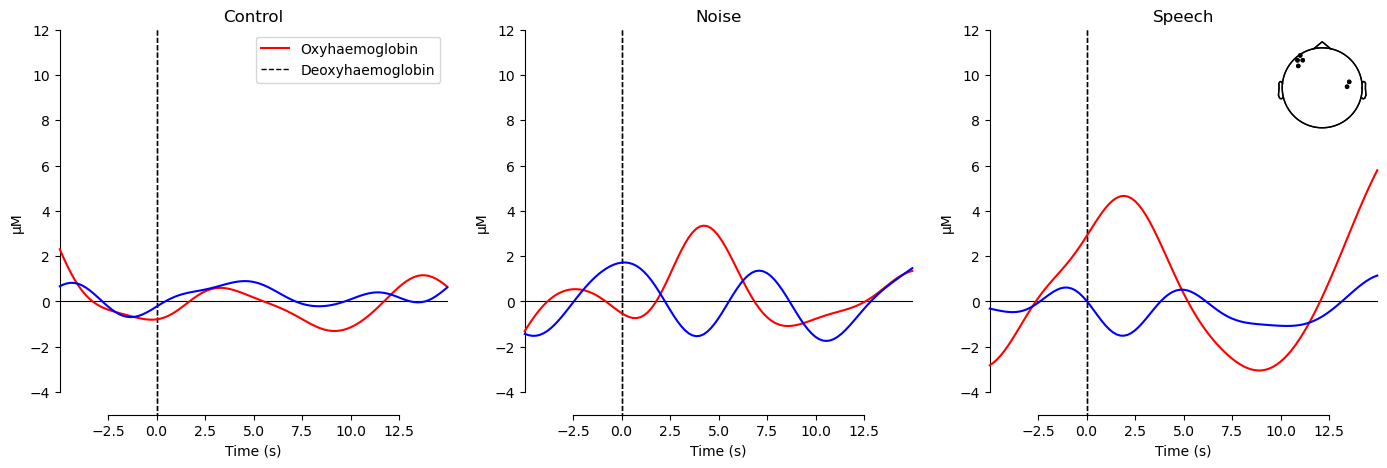

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D2 785', 'S4_D2 830', 'S4_D3 785', 'S4_D3 830', 'S4_D14 785', 'S4_D14 830', 'S5_D2 785', 'S5_D2 830', 'S5_D3 785', 'S5_D3 830', 'S5_D4 785', 'S5_D4 830', 'S5_D5 785', 'S5_D5 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D8 785', 'S6_D8 830', 'S6_D16 785', 'S6_D16 830', 'S7_D6 785', 'S7_D6 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S8_D8 785', 'S8_D8 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830', 'S10_D9 785', 'S10_D9 830', 'S10_D10 785', 'S10_D10 830', 'S10_D11 785', 'S10_D11 830', 'S10_D12 785', 'S10_D12 830', 'S10_D18 785', 'S10_D18 830', 'S11_D11 785', 'S11_D11 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 50
Subject 09, Session 02: 60 epochs left
✅ sub-09 ses-02: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 09, Ses

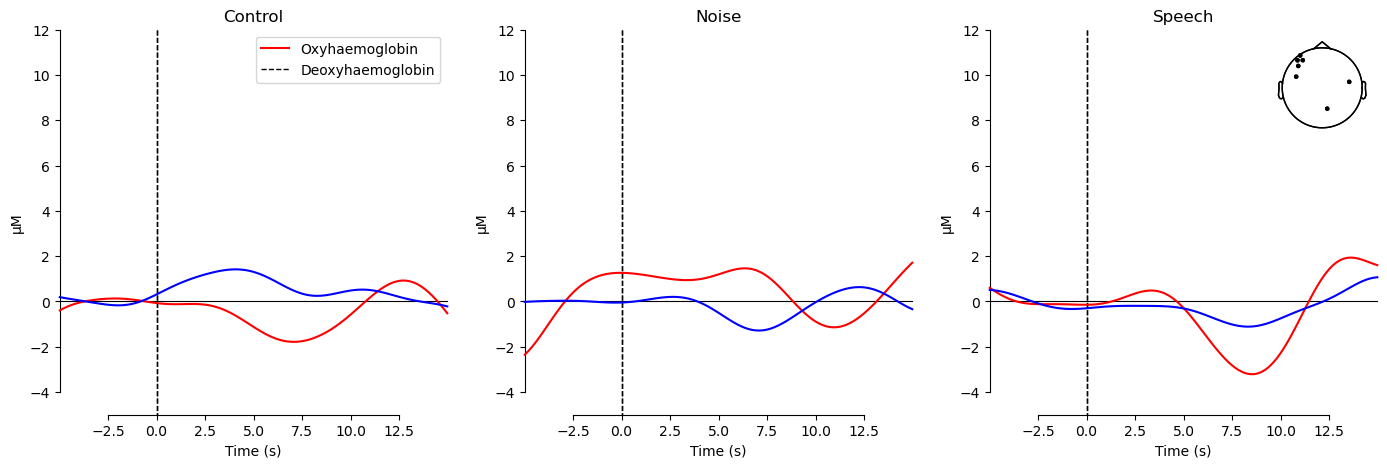

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830']
Number of bad channels: 8
Subject 10, Session 01: 60 epochs left
✅ sub-10 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 10, Session 01


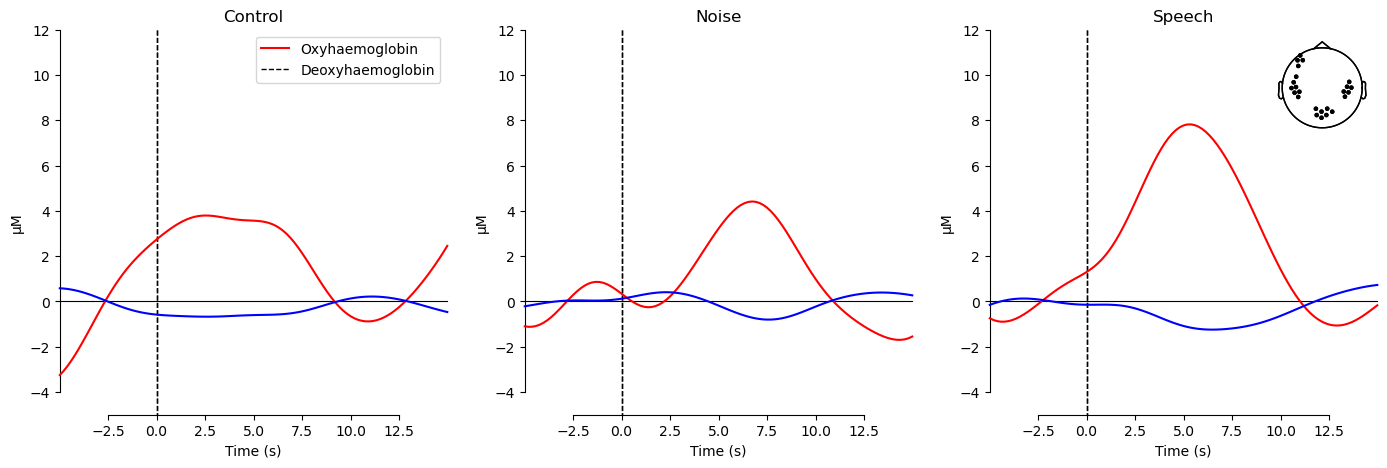

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830']
Number of bad channels: 4
Subject 10, Session 02: 8 epochs left
⚠️ Not enough epochs left for Subject 10, Session 02. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D6 785', 'S6_D6 830', 'S6_D16 785', 'S6_D16 830', 'S7_D6 785', 'S7_D6 830', 'S7_D7 785', 'S7_D7 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 16
Subject 11, Session 01: 60 epochs left
✅ sub-11 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 11, Session 01


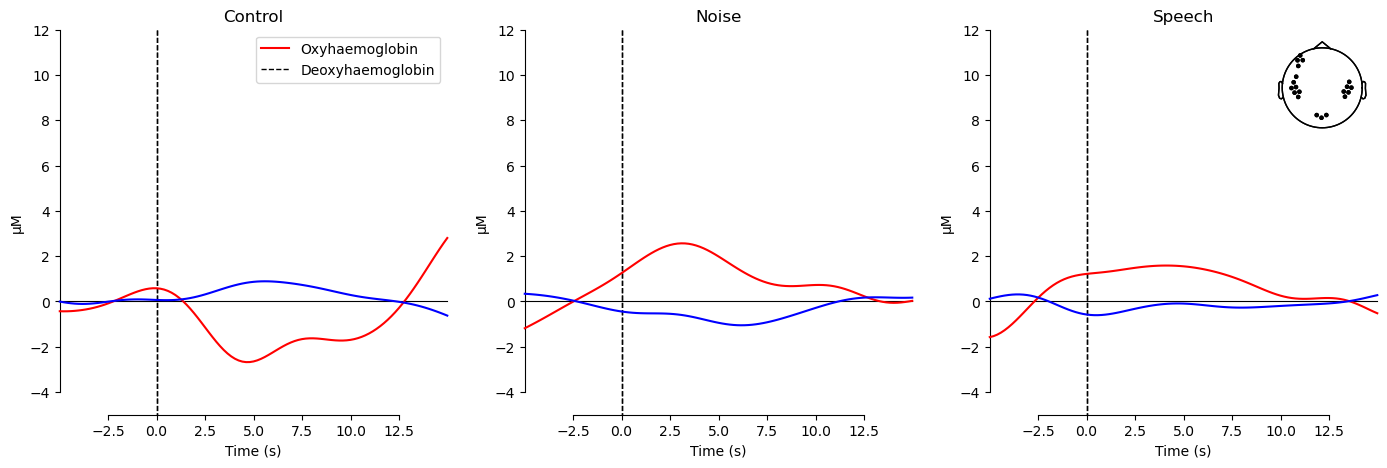

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S6_D16 785', 'S6_D16 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 8
Subject 11, Session 02: 60 epochs left
✅ sub-11 ses-02: 0 CN sig, 1 CS sig; Control epochs removed: 1; Noise epochs removed: 0; Speech epochs removed: 0
Participant 11, Session 02


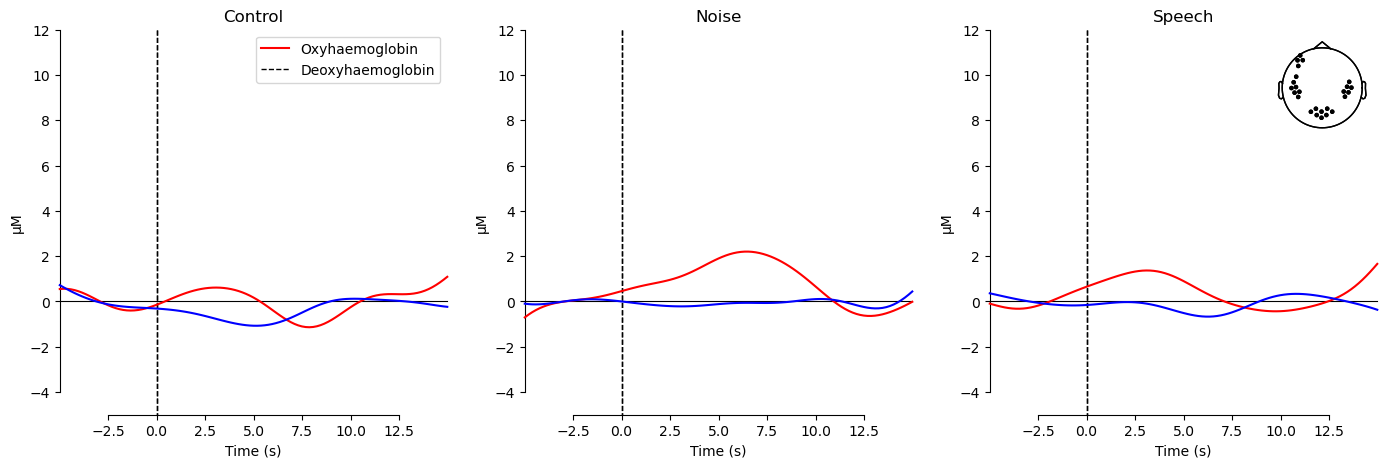

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830']
Number of bad channels: 4
Subject 12, Session 01: 59 epochs left
⚠️ Not enough epochs left for Subject 12, Session 01. Skipping...
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830']
Number of bad channels: 4
Subject 12, Session 02: 60 epochs left
✅ sub-12 ses-02: 0 CN sig, 4 CS sig; Control epochs removed: 0; Noise epochs removed: 0; Speech epochs removed: 0
Participant 12, Session 02


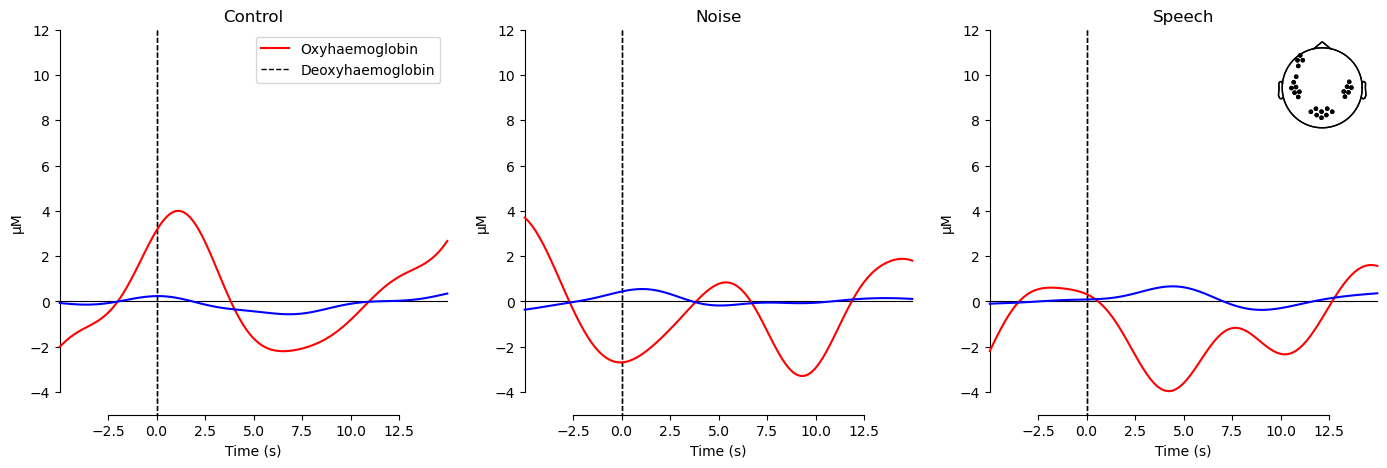

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S6_D16 785', 'S6_D16 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 6
Subject 13, Session 01: 60 epochs left
✅ sub-13 ses-01: 0 CN sig, 0 CS sig; Control epochs removed: 1; Noise epochs removed: 0; Speech epochs removed: 0
Participant 13, Session 01


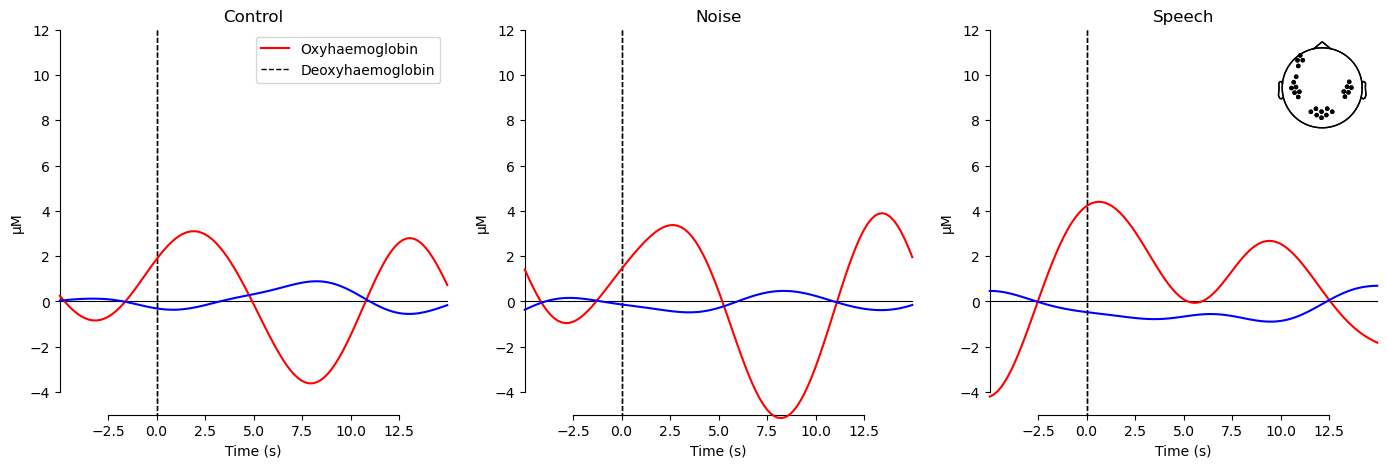

Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S6_D16 785', 'S6_D16 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 6
Subject 13, Session 02: 60 epochs left


KeyboardInterrupt: 

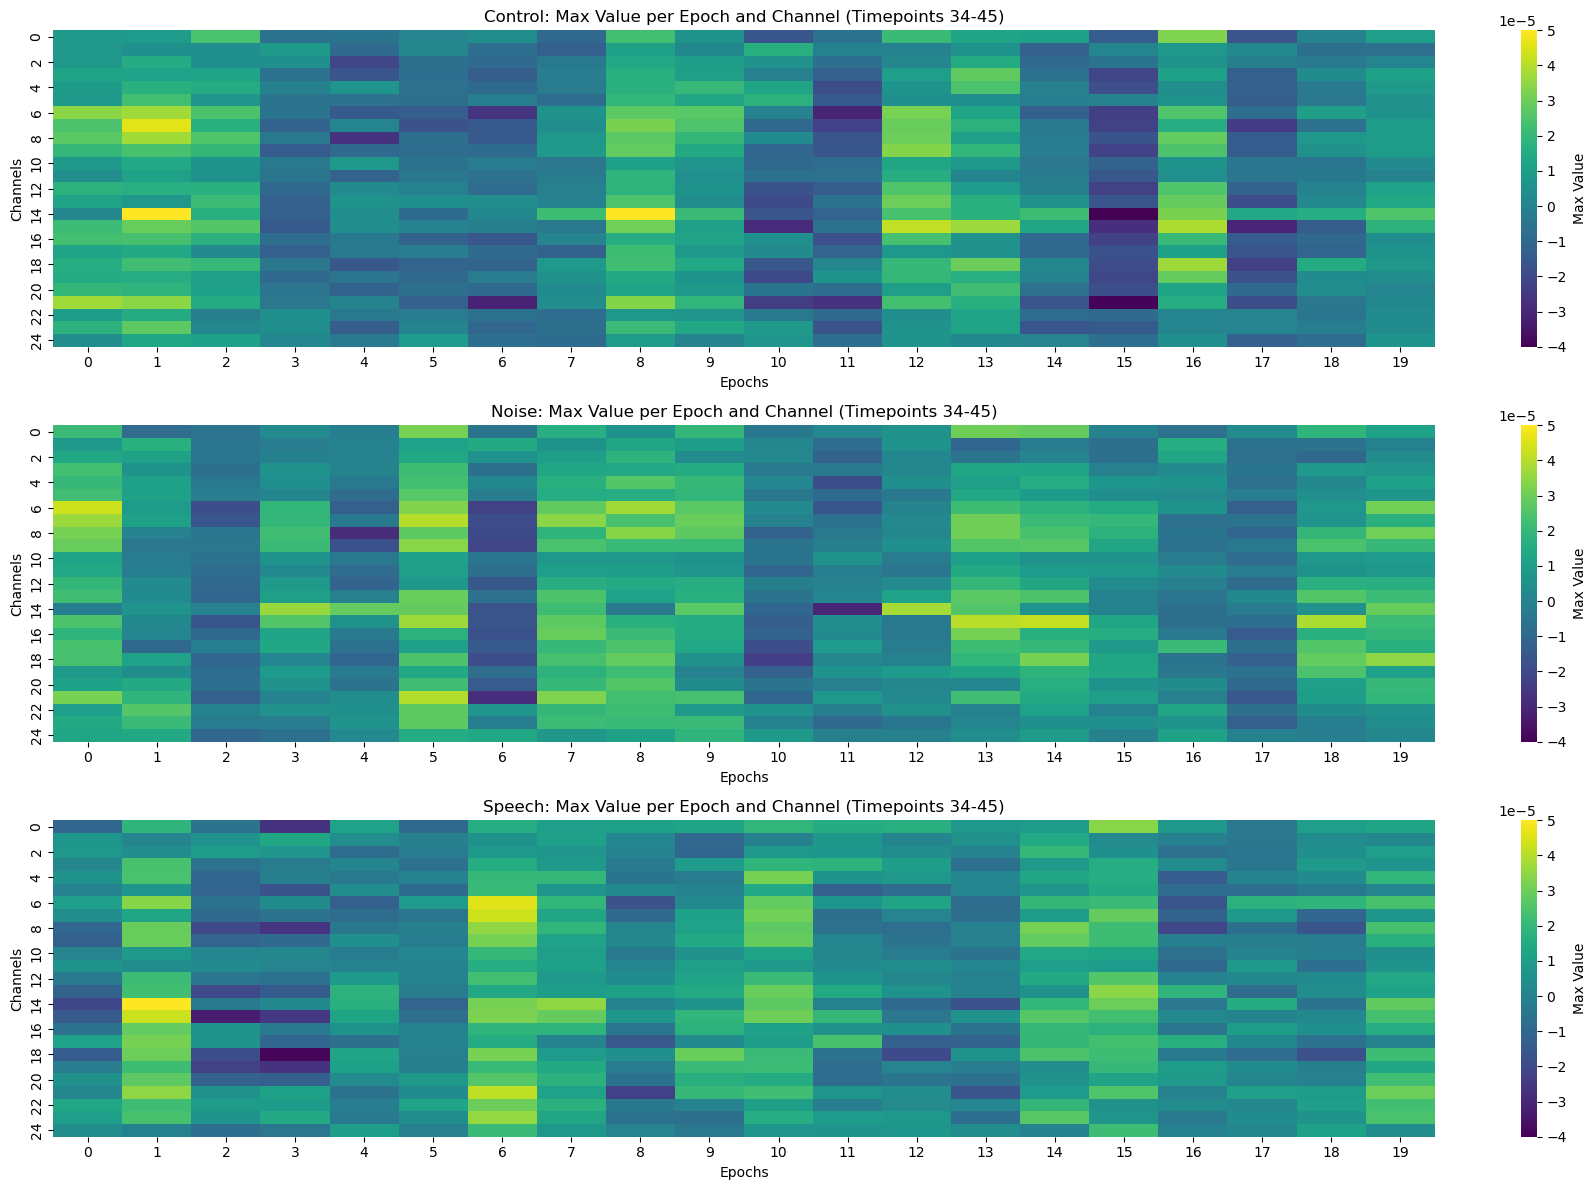

In [582]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

# Create a root output directory
output_root = "individual_analysis_outputs"
os.makedirs(output_root, exist_ok=True)
all_evokeds = defaultdict(list)

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers
#subject_list = subject_list[:1]
print("Detected subjects:", subject_list)

# initialize the list of subjects df it has 2 columns, one for subject and one for session
subjects_df = pd.DataFrame(columns=["subject", "session"])
global_results = []

#for sub in range(1,2):  # Loop over subjects
for sub in subject_list:  # Loop over subjects
    for ses in range(1,3):  
        bids_path = BIDSPath(
            #subject=f"{sub:02d}",
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)
        
        if raw_haemo is None:
            print(f"⚠️ Not enough channels left for Subject {sub}, Session {ses:02d}. Skipping...")
            #print(f"⚠️ Not enough channels left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            continue

        # Check if epochs contain data
        #print(f"Subject {sub:02d}, Session {ses:02d}: {len(epochs)} epochs left")
        print(f"Subject {sub}, Session {ses:02d}: {len(epochs)} epochs left")

        if len(epochs) < 60:
            #print(f"⚠️ Not enough epochs left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            print(f"⚠️ Not enough epochs left for Subject {sub}, Session {ses:02d}. Skipping...")
            # plot the raw_haemo data
            #raw_haemo.plot(n_channels=30, duration=300, show=True)
            
            continue  # Skip this subject/session
        
        
        # === Create output directory for this subject/session ===
        output_dir = os.path.join(output_root, f"sub-{sub}", f"ses-{ses:02d}")
        os.makedirs(output_dir, exist_ok=True)

        # === Clean and prepare data ===
        bad_ch = epochs.info['bads']
        epochs.drop_channels(bad_ch)

        # Get only HbO channels
        hbo_data = epochs.copy().pick("hbo")
        data = hbo_data.get_data()
        info = hbo_data.info.copy()
        ev = events[:, 2]
        index_column = np.arange(0, len(ev)).reshape(-1, 1)
        updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))

        # Time slice
        time_slice = data[:, :, 34:46]
        max_values = np.max(time_slice, axis=2)

        # Indices by condition
        control_idx = updated_matrix[updated_matrix[:, 1] == 1][:, 0]
        noise_idx = updated_matrix[updated_matrix[:, 1] == 2][:, 0]
        speech_idx = updated_matrix[updated_matrix[:, 1] == 3][:, 0]

        control_max = max_values[control_idx, :]
        noise_max = max_values[noise_idx, :]
        speech_max = max_values[speech_idx, :]

        # === Plot before outlier removal ===
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_max, noise_max, speech_max])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel (Timepoints 34-45)')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "heatmaps_before_outlier_removal.png"))
        plt.close()

        # === Outlier removal ===
        def remove_outliers_modified_zscore(matrix, epoch_indices, threshold=3.5):
            medians = np.median(matrix, axis=1)
            mad = np.median(np.abs(medians - np.median(medians)))
            modified_z_scores = 0.6745 * (medians - np.median(medians)) / mad
            outlier_indices = np.where(np.abs(modified_z_scores) > threshold)[0]
            non_outlier_indices = np.setdiff1d(np.arange(matrix.shape[0]), outlier_indices)
            non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)
            matrix[outlier_indices] = non_outlier_mean
            removed_epochs = epoch_indices[outlier_indices]
            return matrix, outlier_indices, removed_epochs

        control_max_cleaned, outier_indices_control, removed_epochs_control = remove_outliers_modified_zscore(control_max.copy(), control_idx)
        noise_max_cleaned, outier_indices_noise, removed_epochs_noise = remove_outliers_modified_zscore(noise_max.copy(), noise_idx)
        speech_max_cleaned, outier_indices_speech, removed_epochs_speech = remove_outliers_modified_zscore(speech_max.copy(), speech_idx)

        # === Plot after outlier removal ===
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_max_cleaned, noise_max_cleaned, speech_max_cleaned])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel (Timepoints 34-45) - Cleaned')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "heatmaps_after_outlier_removal.png"))
        plt.close()

        # === Paired t-tests ===
        min_epochs = min(control_max_cleaned.shape[0], noise_max_cleaned.shape[0], speech_max_cleaned.shape[0])
        control_trimmed = control_max_cleaned[:min_epochs, :]
        noise_trimmed = noise_max_cleaned[:min_epochs, :]
        speech_trimmed = speech_max_cleaned[:min_epochs, :]

        p_cn = np.array([ttest_rel(control_trimmed[:, ch], noise_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        p_cs = np.array([ttest_rel(control_trimmed[:, ch], speech_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        ch_names = hbo_data.info['ch_names']

        # === Significant channels ===
        sig_cn = [ch_names[i] for i in np.where(p_cn < 0.05)[0]]
        sig_cs = [ch_names[i] for i in np.where(p_cs < 0.05)[0]]

        # === Save significant channels to CSV ===
        results_df = pd.DataFrame({
            "Condition": ["Control vs Noise"] * len(sig_cn) + ["Control vs Speech"] * len(sig_cs),
            "Channel": sig_cn + sig_cs,
        })
        results_df.to_csv(os.path.join(output_dir, "significant_channels.csv"), index=False)

        for ch in sig_cn:
            global_results.append({
                "Subject": f"sub-{sub}",
                "Session": f"ses-{ses:02d}",
                "Condition": "Control vs Noise",
                "Channel": ch
            })

        for ch in sig_cs:
            global_results.append({
                "Subject": f"sub-{sub}",
                "Session": f"ses-{ses:02d}",
                "Condition": "Control vs Speech",
                "Channel": ch
            })

        
        # Optional print
        print(f"✅ sub-{sub} ses-{ses:02d}: {len(sig_cn)} CN sig, {len(sig_cs)} CS sig; Control epochs removed: {len(outier_indices_control)}; Noise epochs removed: {len(outier_indices_noise)}; Speech epochs removed: {len(outier_indices_speech)}")
        
        # If the subject has not been skipped save in a dataframe the name and session
        subjects_df = pd.concat([subjects_df, pd.DataFrame({"subject": [sub], "session": [ses]})], ignore_index=True)
        
        indiv_evoked = defaultdict(list)
        # For each individual subject, plot the evoked responses
        for condition in epochs.event_id:
            indiv_evoked[condition]= (epochs[condition].average())
        
        fig, axes = plt.subplots(nrows=1, ncols=len(indiv_evoked), figsize=(17, 5))
        lims = dict(hbo=[-5, 12], hbr=[-5, 12])
        
        # print participant number and session
        print(f"Participant {sub}, Session {ses:02d}")

        for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
            for idx, evoked in enumerate(indiv_evoked):
                plot_compare_evokeds(
                    {evoked: indiv_evoked[evoked]},
                    combine="mean",
                    picks=pick,
                    axes=axes[idx],
                    show=False,
                    colors=[color],
                    legend=False,
                    ylim=lims,
                    ci=0.95,
                    show_sensors=idx == 2,
        )
                axes[idx].set_title(f"{evoked}")
        axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])
        
        # show the figure
        plt.show()
        
        
        
        # Save individual-evoked participant data
        for condition in epochs.event_id:
            all_evokeds[condition].append(epochs[condition])

# Save global results after loop
global_df = pd.DataFrame(global_results)
global_csv_path = os.path.join(output_root, "global_significant_channels.csv")
global_df.to_csv(global_csv_path, index=False)

print(f"\n🌍 Global significant channels saved to: {global_csv_path}")


# Save the dataframe to a csv file
subjects_df.to_csv("subjects_df.csv", index=True)


In [576]:

# === Configuration ===
REMOVE_OUTLIERS = False  # Set to False to skip outlier removal

# Create a root output directory
output_root = "individual_analysis_outputs_tDetrending"
os.makedirs(output_root, exist_ok=True)
all_evokeds = defaultdict(list)

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
#subject_list = subject_list[4:5]  # For testing, limit to one subject
print("Detected subjects:", subject_list)



subjects_df = pd.DataFrame(columns=["subject", "session"])
global_results = []
bad_channels_list = []


def remove_outliers_modified_zscore(matrix, epoch_indices, threshold=3.5):
    medians = np.median(matrix, axis=1)
    mad = np.median(np.abs(medians - np.median(medians)))
    modified_z_scores = 0.6745 * (medians - np.median(medians)) / mad
    outlier_indices = np.where(np.abs(modified_z_scores) > threshold)[0]
    non_outlier_indices = np.setdiff1d(np.arange(matrix.shape[0]), outlier_indices)
    non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)
    matrix[outlier_indices] = non_outlier_mean
    removed_epochs = epoch_indices[outlier_indices]
    return matrix, outlier_indices, removed_epochs

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

        if raw_haemo is None or len(epochs) < 10:
            print(f"⚠️ Not enough data for sub-{sub} ses-{ses:02d}. Skipping...")
            continue

        output_dir = os.path.join(output_root, f"sub-{sub}", f"ses-{ses:02d}")
        os.makedirs(output_dir, exist_ok=True)

        bad_ch = epochs.info['bads']
        
        bad_channels_list.append({
            "Subject": f"sub-{sub}",
            "Session": f"ses-{ses:02d}",
            "Bad_Channels": ', '.join(bad_ch)  # join them into a single string
        })

        epochs.drop_channels(bad_ch)
        hbo_data = epochs.copy().pick("hbo")
        data = hbo_data.get_data()
        info = hbo_data.info.copy()
        # Use events AFTER bad epochs have been rejected
        ev = epochs.events[:, 2]  # only surviving epochs
        index_column = np.arange(0, len(ev)).reshape(-1, 1)  # indices 0,1,2,...,len(ev)-1
        updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))
        
        time_slice = data[:, :, 44:55]  # Timepoints 34 to 45 (inclusive)
        #time_slice = data[:, :, 34:46]
        max_values = np.max(time_slice, axis=2)

        control_idx = updated_matrix[updated_matrix[:, 1] == 1][:, 0]
        noise_idx = updated_matrix[updated_matrix[:, 1] == 2][:, 0]
        speech_idx = updated_matrix[updated_matrix[:, 1] == 3][:, 0]

        control_max = max_values[control_idx, :]
        noise_max = max_values[noise_idx, :]
        speech_max = max_values[speech_idx, :]

        if REMOVE_OUTLIERS:
            control_max_cleaned, outier_indices_control, removed_epochs_control = remove_outliers_modified_zscore(control_max.copy(), control_idx)
            noise_max_cleaned, outier_indices_noise, removed_epochs_noise = remove_outliers_modified_zscore(noise_max.copy(), noise_idx)
            speech_max_cleaned, outier_indices_speech, removed_epochs_speech = remove_outliers_modified_zscore(speech_max.copy(), speech_idx)
        else:
            control_max_cleaned = control_max.copy()
            noise_max_cleaned = noise_max.copy()
            speech_max_cleaned = speech_max.copy()
            outier_indices_control = outier_indices_noise = outier_indices_speech = []
            removed_epochs_control = removed_epochs_noise = removed_epochs_speech = []

        filename_suffix = "after_outlier_removal" if REMOVE_OUTLIERS else "raw_no_outlier_removal"

        # Plot heatmaps
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_max_cleaned, noise_max_cleaned, speech_max_cleaned])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel - {filename_suffix}')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"heatmaps_{filename_suffix}.png"))
        plt.close()

        # Paired t-tests
        # Find maximum number of epochs across conditions
        max_epochs = max(control_max_cleaned.shape[0], noise_max_cleaned.shape[0], speech_max_cleaned.shape[0])

        def extend_epochs(matrix, target_len):
            if matrix.shape[0] >= target_len:
                return matrix
            mean_row = np.mean(matrix, axis=0, keepdims=True)
            num_to_add = target_len - matrix.shape[0]
            extra_rows = np.repeat(mean_row, num_to_add, axis=0)
            return np.vstack((matrix, extra_rows))

        # Extend each condition to match max length
        control_trimmed = extend_epochs(control_max_cleaned, max_epochs)
        noise_trimmed = extend_epochs(noise_max_cleaned, max_epochs)
        speech_trimmed = extend_epochs(speech_max_cleaned, max_epochs)
        
        # Plot heatmaps
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_trimmed, noise_trimmed, speech_trimmed])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel - {filename_suffix} - Extended')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"heatmaps_{filename_suffix}_Extended.png"))
        plt.close()


        p_cn = np.array([ttest_rel(control_trimmed[:, ch], noise_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        p_cs = np.array([ttest_rel(control_trimmed[:, ch], speech_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        ch_names = hbo_data.info['ch_names']

        sig_cn = [ch_names[i] for i in np.where(p_cn < 0.05)[0]]
        sig_cs = [ch_names[i] for i in np.where(p_cs < 0.05)[0]]

        results_df = pd.DataFrame({
            "Condition": ["Control vs Noise"] * len(sig_cn) + ["Control vs Speech"] * len(sig_cs),
            "Channel": sig_cn + sig_cs,
        })
        results_df.to_csv(os.path.join(output_dir, "significant_channels.csv"), index=False)

        for ch in sig_cn:
            global_results.append({"Subject": f"sub-{sub}", "Session": f"ses-{ses:02d}", "Condition": "Control vs Noise", "Channel": ch})
        for ch in sig_cs:
            global_results.append({"Subject": f"sub-{sub}", "Session": f"ses-{ses:02d}", "Condition": "Control vs Speech", "Channel": ch})

        print(f"✅ sub-{sub} ses-{ses:02d}: {len(sig_cn)} CN sig, {len(sig_cs)} CS sig; Outlier removal: {'ON' if REMOVE_OUTLIERS else 'OFF'}")

        subjects_df = pd.concat([subjects_df, pd.DataFrame({"subject": [sub], "session": [ses]})], ignore_index=True)

# Save global results
global_df = pd.DataFrame(global_results)
global_csv_path = os.path.join(output_root, "global_significant_channels_outliers_in.csv")
global_df.to_csv(global_csv_path, index=False)
print(f"\n🌍 Global significant channels saved to: {global_csv_path}")

bad_channels_df = pd.DataFrame(bad_channels_list)
bad_channels_path = os.path.join(output_root, "bad_channels_per_subject_session.csv")
bad_channels_df.to_csv(bad_channels_path, index=False)

print(f"\n❗ Bad channels per subject/session saved to: {bad_channels_path}")


subjects_df.to_csv("subjects_df.csv", index=True)  # Save subjects session participation


Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D8 785', 'S6_D8 830', 'S7_D6 785', 'S7_D6 830', 'S7_D8 785', 'S7_D8 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830']
Number of bad channels: 16
✅ sub-01 ses-01: 6 CN sig, 7 CS sig; Outlier removal: OFF
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S7_D6 785', 'S7_D6 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830', 'S10_D18 785', 'S10_D18 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 16
✅ sub-01 ses-02: 0 CN sig, 2 CS sig; Outlier removal: OFF
Re

In [578]:
import pandas as pd

# Load the global CSV
global_df = pd.read_csv("individual_analysis_outputs_tDetrending/global_significant_channels_outliers_in.csv")  # Change path if needed

# Function to count channel repetitions for a specific condition
def count_channels(df, condition_name):
    filtered = df[df["Condition"] == condition_name]
    channel_counts = filtered["Channel"].value_counts().reset_index()
    channel_counts.columns = ["Channel", "Count"]
    return channel_counts

# Get counts for both conditions
control_vs_noise_counts = count_channels(global_df, "Control vs Noise")
control_vs_speech_counts = count_channels(global_df, "Control vs Speech")

# Save to separate CSVs
control_vs_noise_counts.to_csv("significant_channels_Detrending_control_vs_noise_outliers_in.csv", index=False)
control_vs_speech_counts.to_csv("significant_channels_Detrending_control_vs_speech_outliers_in.csv", index=False)

print(control_vs_noise_counts)

        Channel  Count
0   S10_D11 hbo     10
1   S11_D12 hbo     10
2   S11_D11 hbo     10
3     S5_D2 hbo      7
4     S5_D3 hbo      7
5   S10_D12 hbo      7
6    S10_D9 hbo      7
7   S10_D10 hbo      6
8     S5_D5 hbo      5
9    S12_D1 hbo      5
10    S5_D4 hbo      5
11    S8_D7 hbo      5
12    S1_D1 hbo      5
13    S7_D7 hbo      4
14    S4_D2 hbo      4
15    S2_D1 hbo      4
16    S3_D1 hbo      4
17    S3_D2 hbo      4
18    S4_D3 hbo      3
19    S6_D8 hbo      3
20    S7_D6 hbo      2
21    S9_D8 hbo      2
22    S7_D8 hbo      2
23    S8_D8 hbo      1
24    S6_D6 hbo      1


In [580]:
import pandas as pd

# Load the global CSV
global_df = pd.read_csv("individual_analysis_outputs_tDetrending/global_significant_channels_outliers_in.csv")  # Change path if needed

# Function to count channel repetitions and list subjects/sessions
def count_channels(df, condition_name):
    filtered = df[df["Condition"] == condition_name]
    
    # Group by Channel, aggregate count and list subjects/sessions
    channel_summary = (
        filtered.groupby("Channel")
        .agg(
            Count=("Channel", "size"),
            Subjects_Sessions=("Subject", lambda x: [
                f"{sub}_{ses}" for sub, ses in zip(filtered.loc[x.index, "Subject"], filtered.loc[x.index, "Session"])
            ])
        )
        .reset_index()
    )
    
    # Convert Subjects_Sessions list to a comma-separated string
    channel_summary["Subjects_Sessions"] = channel_summary["Subjects_Sessions"].apply(lambda x: ", ".join(x))
    
    # Sort by Count descending
    channel_summary = channel_summary.sort_values(by="Count", ascending=False).reset_index(drop=True)
    
    return channel_summary

# Get counts for both conditions
control_vs_noise_counts = count_channels(global_df, "Control vs Noise")
control_vs_speech_counts = count_channels(global_df, "Control vs Speech")

# Save to separate CSVs
control_vs_noise_counts.to_csv("significant_channels_Detrending_control_vs_noise_outliers_in.csv", index=False)
control_vs_speech_counts.to_csv("significant_channels_Detrending_control_vs_speech_outliers_in.csv", index=False)

# Print
print(control_vs_noise_counts)
print(control_vs_speech_counts)


        Channel  Count                                  Subjects_Sessions
0   S10_D11 hbo     10  sub-01_ses-01, sub-02_ses-02, sub-03_ses-02, s...
1   S11_D12 hbo     10  sub-01_ses-01, sub-02_ses-02, sub-03_ses-02, s...
2   S11_D11 hbo     10  sub-01_ses-01, sub-02_ses-02, sub-13_ses-02, s...
3    S10_D9 hbo      7  sub-04_ses-02, sub-07_ses-02, sub-08_ses-01, s...
4   S10_D12 hbo      7  sub-01_ses-01, sub-02_ses-02, sub-04_ses-02, s...
5     S5_D2 hbo      7  sub-01_ses-01, sub-02_ses-02, sub-03_ses-02, s...
6     S5_D3 hbo      7  sub-01_ses-01, sub-04_ses-02, sub-08_ses-01, s...
7   S10_D10 hbo      6  sub-04_ses-02, sub-14_ses-01, sub-20_ses-01, s...
8    S12_D1 hbo      5  sub-08_ses-01, sub-11_ses-01, sub-14_ses-01, s...
9     S8_D7 hbo      5  sub-03_ses-02, sub-04_ses-02, sub-07_ses-02, s...
10    S1_D1 hbo      5  sub-04_ses-02, sub-08_ses-01, sub-14_ses-01, s...
11    S5_D5 hbo      5  sub-02_ses-02, sub-04_ses-02, sub-08_ses-01, s...
12    S5_D4 hbo      5  sub-08_ses-01,

In [ ]:
import pandas as pd

# === Load the bad channels CSV ===
bad_channels_df = pd.read_csv("individual_analysis_outputs/bad_channels_per_subject_session.csv")

# === Create a list to store all bad channels ===
all_bad_channels = []

# Loop through each row and split the channels
for bads in bad_channels_df["Bad_Channels"].dropna():  # drop NaNs (sessions with no bad channels)
    channels = [ch.strip() for ch in bads.split(",")]  # split and remove extra spaces
    all_bad_channels.extend(channels)

# === Filter to keep only channels ending with "hbo" ===
hbo_bad_channels = [ch for ch in all_bad_channels if ch.endswith("hbo")]

# === Count how many times each HbO channel appears ===
hbo_bad_channel_counts = pd.Series(hbo_bad_channels).value_counts().reset_index()
hbo_bad_channel_counts.columns = ["Channel", "Count"]

# === Save to CSV ===
hbo_bad_channel_counts.to_csv("individual_analysis_outputs/hbo_bad_channel_frequencies.csv", index=False)

print("\n✅ HbO bad channel counts saved to: individual_analysis_outputs/hbo_bad_channel_frequencies.csv")
print(hbo_bad_channel_counts)



✅ HbO bad channel counts saved to: individual_analysis_outputs/hbo_bad_channel_frequencies.csv
        Channel  Count
0     S7_D8 hbo     27
1     S7_D6 hbo     24
2     S9_D8 hbo     19
3     S6_D6 hbo     17
4     S5_D3 hbo     13
5     S7_D7 hbo     12
6     S8_D7 hbo     12
7     S6_D8 hbo     10
8     S8_D8 hbo     10
9    S10_D9 hbo      8
10    S5_D5 hbo      7
11  S10_D10 hbo      6
12  S10_D11 hbo      5
13    S5_D4 hbo      4
14    S5_D2 hbo      4
15  S10_D12 hbo      4
16    S4_D3 hbo      4
17    S4_D2 hbo      4
18    S3_D2 hbo      1


# Debug of <10 epochs problem

In [487]:

# === Configuration ===
REMOVE_OUTLIERS = False  # Set to False to skip outlier removal

# Create a root output directory
output_root = "individual_analysis_outputs"
os.makedirs(output_root, exist_ok=True)
all_evokeds = defaultdict(list)

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# === Configuration for participant-session selection ===
selected_subject_sessions = [
    ("04", "01"),
    ("04", "02"),
    ("07", "01"),
    ("07", "02"),
    ("08", "01"),
    ("08", "02"),
    ("12", "01"),
    ("12", "02"),
    ("20", "01"),
]

print("Selected subject-session pairs:")
for subj, sess in selected_subject_sessions:
    print(f"sub-{subj} ses-{sess}")

subjects_df = pd.DataFrame(columns=["subject", "session"])
global_results = []
bad_channels_list = []



def remove_outliers_modified_zscore(matrix, epoch_indices, threshold=3.5):
    medians = np.median(matrix, axis=1)
    mad = np.median(np.abs(medians - np.median(medians)))
    modified_z_scores = 0.6745 * (medians - np.median(medians)) / mad
    outlier_indices = np.where(np.abs(modified_z_scores) > threshold)[0]
    non_outlier_indices = np.setdiff1d(np.arange(matrix.shape[0]), outlier_indices)
    non_outlier_mean = np.mean(matrix[non_outlier_indices], axis=0)
    matrix[outlier_indices] = non_outlier_mean
    removed_epochs = epoch_indices[outlier_indices]
    return matrix, outlier_indices, removed_epochs

for sub, ses in selected_subject_sessions:
    #for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=ses,
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

        if raw_haemo is None or len(epochs) < 10:
            print(f"⚠️ Not enough data for sub-{sub} ses-{ses}. Skipping...")
            continue

        output_dir = os.path.join(output_root, f"sub-{sub}", f"ses-{ses}")
        os.makedirs(output_dir, exist_ok=True)

        bad_ch = epochs.info['bads']
        
        bad_channels_list.append({
            "Subject": f"sub-{sub}",
            "Session": f"ses-{ses}",
            "Bad_Channels": ', '.join(bad_ch)  # join them into a single string
        })

        epochs.drop_channels(bad_ch)
        hbo_data = epochs.copy().pick("hbo")
        data = hbo_data.get_data()
        info = hbo_data.info.copy()
        # Use events AFTER bad epochs have been rejected
        ev = epochs.events[:, 2]  # only surviving epochs
        index_column = np.arange(0, len(ev)).reshape(-1, 1)  # indices 0,1,2,...,len(ev)-1
        updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))

        time_slice = data[:, :, 34:46]
        max_values = np.max(time_slice, axis=2)

        control_idx = updated_matrix[updated_matrix[:, 1] == 1][:, 0]
        noise_idx = updated_matrix[updated_matrix[:, 1] == 2][:, 0]
        speech_idx = updated_matrix[updated_matrix[:, 1] == 3][:, 0]

        control_max = max_values[control_idx, :]
        noise_max = max_values[noise_idx, :]
        speech_max = max_values[speech_idx, :]

        if REMOVE_OUTLIERS:
            control_max_cleaned, outier_indices_control, removed_epochs_control = remove_outliers_modified_zscore(control_max.copy(), control_idx)
            noise_max_cleaned, outier_indices_noise, removed_epochs_noise = remove_outliers_modified_zscore(noise_max.copy(), noise_idx)
            speech_max_cleaned, outier_indices_speech, removed_epochs_speech = remove_outliers_modified_zscore(speech_max.copy(), speech_idx)
        else:
            control_max_cleaned = control_max.copy()
            noise_max_cleaned = noise_max.copy()
            speech_max_cleaned = speech_max.copy()
            outier_indices_control = outier_indices_noise = outier_indices_speech = []
            removed_epochs_control = removed_epochs_noise = removed_epochs_speech = []

        filename_suffix = "after_outlier_removal" if REMOVE_OUTLIERS else "raw_no_outlier_removal"

        # Plot heatmaps
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_max_cleaned, noise_max_cleaned, speech_max_cleaned])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel - {filename_suffix}')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"heatmaps_{filename_suffix}.png"))
        plt.close()

        # Paired t-tests
        # Find maximum number of epochs across conditions
        max_epochs = max(control_max_cleaned.shape[0], noise_max_cleaned.shape[0], speech_max_cleaned.shape[0])

        def extend_epochs(matrix, target_len):
            if matrix.shape[0] >= target_len:
                return matrix
            mean_row = np.mean(matrix, axis=0, keepdims=True)
            num_to_add = target_len - matrix.shape[0]
            extra_rows = np.repeat(mean_row, num_to_add, axis=0)
            return np.vstack((matrix, extra_rows))

        # Extend each condition to match max length
        control_trimmed = extend_epochs(control_max_cleaned, max_epochs)
        noise_trimmed = extend_epochs(noise_max_cleaned, max_epochs)
        speech_trimmed = extend_epochs(speech_max_cleaned, max_epochs)
        
        # Plot heatmaps
        plt.figure(figsize=(18, 12))
        for i, (name, mat) in enumerate(zip(["Control", "Noise", "Speech"], [control_trimmed, noise_trimmed, speech_trimmed])):
            plt.subplot(3, 1, i + 1)
            sns.heatmap(mat.T, cmap="viridis", cbar_kws={'label': 'Max Value'}, vmin=-4e-5, vmax=5e-5)
            plt.title(f'{name}: Max Value per Epoch and Channel - {filename_suffix} - Extended')
            plt.xlabel('Epochs')
            plt.ylabel('Channels')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"heatmaps_{filename_suffix}_Extended.png"))
        plt.close()


        p_cn = np.array([ttest_rel(control_trimmed[:, ch], noise_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        p_cs = np.array([ttest_rel(control_trimmed[:, ch], speech_trimmed[:, ch])[1] for ch in range(control_trimmed.shape[1])])
        ch_names = hbo_data.info['ch_names']

        sig_cn = [ch_names[i] for i in np.where(p_cn < 0.05)[0]]
        sig_cs = [ch_names[i] for i in np.where(p_cs < 0.05)[0]]

        results_df = pd.DataFrame({
            "Condition": ["Control vs Noise"] * len(sig_cn) + ["Control vs Speech"] * len(sig_cs),
            "Channel": sig_cn + sig_cs,
        })
        results_df.to_csv(os.path.join(output_dir, "significant_channels.csv"), index=False)

        for ch in sig_cn:
            global_results.append({"Subject": f"sub-{sub}", "Session": f"ses-{ses}", "Condition": "Control vs Noise", "Channel": ch})
        for ch in sig_cs:
            global_results.append({"Subject": f"sub-{sub}", "Session": f"ses-{ses}", "Condition": "Control vs Speech", "Channel": ch})

        print(f"✅ sub-{sub} ses-{ses}: {len(sig_cn)} CN sig, {len(sig_cs)} CS sig; Outlier removal: {'ON' if REMOVE_OUTLIERS else 'OFF'}")

        subjects_df = pd.concat([subjects_df, pd.DataFrame({"subject": [sub], "session": [ses]})], ignore_index=True)

# Save global results
global_df = pd.DataFrame(global_results)
global_csv_path = os.path.join(output_root, "global_significant_channels_outliers_in.csv")
global_df.to_csv(global_csv_path, index=False)
print(f"\n🌍 Global significant channels saved to: {global_csv_path}")

bad_channels_df = pd.DataFrame(bad_channels_list)
bad_channels_path = os.path.join(output_root, "bad_channels_per_subject_session.csv")
bad_channels_df.to_csv(bad_channels_path, index=False)

print(f"\n❗ Bad channels per subject/session saved to: {bad_channels_path}")


subjects_df.to_csv("subjects_df.csv", index=True)  # Save subjects session participation


Selected subject-session pairs:
sub-04 ses-01
sub-04 ses-02
sub-07 ses-01
sub-07 ses-02
sub-08 ses-01
sub-08 ses-02
sub-12 ses-01
sub-12 ses-02
sub-20 ses-01
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S6_D16 785', 'S6_D16 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830', 'S11_D19 785', 'S11_D19 830']
Number of bad channels: 10
✅ sub-04 ses-01: 1 CN sig, 2 CS sig; Outlier removal: OFF
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S6_D16 785', 'S6_D16 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830']
Number of bad channels: 8
✅ sub-04 ses-02: 11 CN sig, 12 CS sig; Outlier removal: OFF
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S4_D14 785', 'S4_D14 830', 'S5_D15 785'

In [488]:
import pandas as pd

# Load the global CSV
global_df = pd.read_csv("individual_analysis_outputs/global_significant_channels_outliers_out.csv")  # Change path if needed

# Function to count channel repetitions for a specific condition
def count_channels(df, condition_name):
    filtered = df[df["Condition"] == condition_name]
    channel_counts = filtered["Channel"].value_counts().reset_index()
    channel_counts.columns = ["Channel", "Count"]
    return channel_counts

# Get counts for both conditions
control_vs_noise_counts = count_channels(global_df, "Control vs Noise")
control_vs_speech_counts = count_channels(global_df, "Control vs Speech")

print(control_vs_noise_counts)
print(control_vs_speech_counts)


        Channel  Count
0     S1_D1 hbo      3
1     S7_D7 hbo      3
2   S11_D11 hbo      3
3   S10_D10 hbo      2
4     S2_D1 hbo      2
5     S4_D2 hbo      2
6     S8_D7 hbo      2
7     S6_D8 hbo      2
8   S10_D12 hbo      1
9     S3_D2 hbo      1
10    S5_D5 hbo      1
11    S5_D2 hbo      1
12  S10_D11 hbo      1
13   S10_D9 hbo      1
14    S7_D6 hbo      1
15    S3_D1 hbo      1
16    S4_D3 hbo      1
17    S5_D3 hbo      1
18  S11_D12 hbo      1
        Channel  Count
0     S5_D3 hbo      4
1   S10_D12 hbo      4
2     S8_D7 hbo      4
3     S8_D8 hbo      3
4     S5_D4 hbo      3
5     S5_D5 hbo      3
6     S7_D7 hbo      3
7   S10_D10 hbo      3
8   S10_D11 hbo      3
9    S10_D9 hbo      3
10    S1_D1 hbo      2
11    S7_D6 hbo      2
12    S5_D2 hbo      2
13    S3_D2 hbo      2
14  S11_D11 hbo      2
15    S4_D3 hbo      1
16    S4_D2 hbo      1
17    S6_D8 hbo      1
18    S6_D6 hbo      1


# Mean Interval all participants

In [75]:
""" from mne import grand_average
# === Setup ===
output_root = "individual_analysis_outputs"
os.makedirs(output_root, exist_ok=True)

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"
subject_list = sorted([d.replace("sub-", "") for d in os.listdir(bids_root) if d.startswith("sub-")])
#subject_list = subject_list[:5]  # For testing, limit to one subject
print("Detected subjects:", subject_list)

all_evokeds = defaultdict(list)
subjects_df = pd.DataFrame(columns=["subject", "session"])

# === Process each subject and session ===
for sub in subject_list:
    for ses in range(1, 3):  # Session 1 and 2
        bids_path = BIDSPath(
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

        if raw_haemo is None or len(epochs) < 10:
            print(f"⚠️ Skipping Subject {sub}, Session {ses:02d} (not enough data)")
            continue

        print(f"✅ Processing Subject {sub}, Session {ses:02d} with {len(epochs)} epochs")

        # Save subject/session info
        subjects_df = pd.concat([subjects_df, pd.DataFrame({"subject": [sub], "session": [ses]})], ignore_index=True)

        # Compute evoked per condition
        for condition in epochs.event_id:
            evoked = epochs[condition].average()
            all_evokeds[condition].append(evoked)

# === After looping through all participants ===

# Grand average per condition
grand_averages = {}
for condition, evokeds in all_evokeds.items():
    grand_avg = grand_average(evokeds)
    grand_averages[condition] = grand_avg

# Extract max and min between 4 and 6 seconds
max_min_results = []

for condition, grand_avg in grand_averages.items():
    times = grand_avg.times  # time vector
    mask = (times >= 4.0) & (times <= 6.0)
    data = grand_avg.data[:, mask]  # channels x selected time points

    max_val = np.max(data)
    min_val = np.min(data)

    print(f"🔹 Condition '{condition}': Max = {max_val:.4e}, Min = {min_val:.4e}")

    max_min_results.append({
        "Condition": condition,
        "Max_4-6s": max_val,
        "Min_4-6s": min_val
    })

# Save max/min results
max_min_df = pd.DataFrame(max_min_results)
max_min_csv_path = os.path.join(output_root, "grand_average_max_min_4_6s.csv")
max_min_df.to_csv(max_min_csv_path, index=False)

print(f"\n📝 Grand average max/min values saved to: {max_min_csv_path}")
# Save subject/session dataframe
subjects_df.to_csv(os.path.join(output_root, "subjects_df.csv"), index=False)
print(f"📝 Subjects dataframe saved to: {os.path.join(output_root, 'subjects_df.csv')}") """

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sarab\AppData\Local\Temp\ipykernel_28972\1251248373.py:1: SyntaxWarning: invalid escape sequence '\D'
  """ from mne import grand_average


' from mne import grand_average\n# === Setup ===\noutput_root = "individual_analysis_outputs"\nos.makedirs(output_root, exist_ok=True)\n\nbids_root = r"C:\\Datasets\\Test-retest study\x08ids_dataset"\nsubject_list = sorted([d.replace("sub-", "") for d in os.listdir(bids_root) if d.startswith("sub-")])\n#subject_list = subject_list[:5]  # For testing, limit to one subject\nprint("Detected subjects:", subject_list)\n\nall_evokeds = defaultdict(list)\nsubjects_df = pd.DataFrame(columns=["subject", "session"])\n\n# === Process each subject and session ===\nfor sub in subject_list:\n    for ses in range(1, 3):  # Session 1 and 2\n        bids_path = BIDSPath(\n            subject=f"{sub}",\n            session=f"{ses:02d}",\n            task="auditory",\n            datatype="nirs",\n            root=bids_root,\n            suffix="nirs",\n            extension=".snirf",\n        )\n\n        # Analyse data\n        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_pa

In [ ]:
# === Paths ===
bids_root = r"C:\Datasets\Test-retest study\bids_dataset"
output_root = "individual_analysis_outputs"
os.makedirs(output_root, exist_ok=True)

# === List subjects ===
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

# === Storage ===
all_evokeds = defaultdict(list)
max_min_results = []

# === Loop over subjects and sessions ===
for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Load your data
        raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)
        
        if raw_haemo is None or len(epochs) < 10:
            print(f"⚠️ Skipping sub-{sub} ses-{ses:02d} (not enough channels or epochs)")
            continue

        # Create subject/session output directory
        output_dir = os.path.join(output_root, f"sub-{sub}", f"ses-{ses:02d}")
        os.makedirs(output_dir, exist_ok=True)

        # Drop bad channels
        epochs.drop_channels(epochs.info['bads'])

        # Pick only HbO
        hbo_epochs = epochs.copy().pick("hbo")

        # === Compute individual evokeds ===
        indiv_evoked = {}
        for condition in hbo_epochs.event_id:
            evoked = hbo_epochs[condition].average()
            indiv_evoked[condition] = evoked
            all_evokeds[condition].append(evoked)

            # Extract max/min between 4 and 6 seconds
            times = evoked.times
            idx = np.where((times >= 4) & (times <= 6))[0]

            if len(idx) == 0:
                print(f"⚠️ No time points between 4-6s for sub-{sub} ses-{ses:02d} condition {condition}")
                continue

            signal = evoked.data[:, idx]  # (n_channels, selected_times)
            max_val = np.max(signal)
            min_val = np.min(signal)

            max_min_results.append({
                "Subject": f"sub-{sub}",
                "Session": f"ses-{ses:02d}",
                "Condition": condition,
                "Max_4to6s": max_val,
                "Min_4to6s": min_val
            })

        print(f"✅ Finished sub-{sub} ses-{ses:02d}")

# === Save the Max/Min results ===
max_min_df = pd.DataFrame(max_min_results)
max_min_df_path = os.path.join(output_root, "max_min_per_subject.csv")
max_min_df.to_csv(max_min_df_path, index=False)
print(f"📄 Max/Min results saved to {max_min_df_path}")

# === Compute grand averages and SDs ===
#grand_averages = {}
grand_average_max_min = []

for condition, evokeds in all_evokeds.items():
    # print(condition)
    # grand_avg = grand_average(evokeds)
    # grand_averages[condition] = grand_avg

    # Collect all subjects' max/min values for this condition
    condition_max_values = max_min_df[max_min_df['Condition'] == condition]['Max_4to6s'].values
    condition_min_values = max_min_df[max_min_df['Condition'] == condition]['Min_4to6s'].values

    grand_average_max_min.append({
        "Condition": condition,
        "Max_4-6s": np.mean(condition_max_values),
        "SD_Max_4-6s": np.std(condition_max_values, ddof=1),
        "Min_4-6s": np.mean(condition_min_values),
        "SD_Min_4-6s": np.std(condition_min_values, ddof=1)
    })

# Save the grand average max/min (+ SD) to CSV
grand_avg_df = pd.DataFrame(grand_average_max_min)
grand_avg_df_path = os.path.join(output_root, "grand_average_max_min_4_6s.csv")
grand_avg_df.to_csv(grand_avg_df_path, index=False)
print(f"📄 Grand average (mean + SD) saved to {grand_avg_df_path}")





Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D8 785', 'S6_D8 830', 'S7_D6 785', 'S7_D6 830', 'S7_D8 785', 'S7_D8 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830']
Number of bad channels: 16
✅ Finished sub-01 ses-01
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S7_D6 785', 'S7_D6 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S8_D17 785', 'S8_D17 830', 'S9_D8 785', 'S9_D8 830', 'S10_D18 785', 'S10_D18 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 16
✅ Finished sub-01 ses-02
Removing break annotations for the orginal raw...
Removing break ann

In [58]:
for condition, evokeds in all_evokeds.items():
    print(condition)
    grand_avg = grand_average(evokeds)
    grand_averages[condition] = grand_avg

    # Collect all subjects' max/min values for this condition
    condition_max_values = max_min_df[max_min_df['Condition'] == condition]['Max_4to6s'].values
    condition_min_values = max_min_df[max_min_df['Condition'] == condition]['Min_4to6s'].values

    grand_average_max_min.append({
        "Condition": condition,
        "Max_4-6s": np.mean(condition_max_values),
        "SD_Max_4-6s": np.std(condition_max_values, ddof=1),
        "Min_4-6s": np.mean(condition_min_values),
        "SD_Min_4-6s": np.std(condition_min_values, ddof=1)
    })

# Save the grand average max/min (+ SD) to CSV
grand_avg_df = pd.DataFrame(grand_average_max_min)
grand_avg_df_path = os.path.join(output_root, "grand_average_max_min_4_6s.csv")
grand_avg_df.to_csv(grand_avg_df_path, index=False)
print(f"📄 Grand average (mean + SD) saved to {grand_avg_df_path}")


Control
Noise
Speech
📄 Grand average (mean + SD) saved to individual_analysis_outputs\grand_average_max_min_4_6s.csv


In [69]:
for condition, grand_avg in grand_averages.items():
    times = grand_avg.times  # time vector
    mask = (times >= 0) & (times <= 15)
    data = grand_avg.data[:, mask]  # channels x selected time points

    max_val = np.max(data)
    min_val = np.min(data)

    print(f"🔹 Condition '{condition}': Max = {max_val:.4e}, Min = {min_val:.4e}")


🔹 Condition 'Control': Max = 3.5185e-07, Min = -8.1529e-07
🔹 Condition 'Noise': Max = 3.0325e-06, Min = -7.1305e-07
🔹 Condition 'Speech': Max = 3.4620e-06, Min = -1.2904e-06


In [73]:
grand_avg.data.shape

(6, 105)

In [74]:
times.shape

(105,)

In [ ]:
times = grand_avg.times 
mask = (times >= 0) & (times <= 15)
data = grand_avg.data[:, mask]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [53]:
import pandas as pd
import os

# === Step 1: Load the CSVs ===
output_root = 'individual_analysis_outputs'
max_min_df = pd.read_csv(os.path.join(output_root, "max_min_per_subject.csv"))
grand_avg_df = pd.read_csv(os.path.join(output_root, "grand_average_max_min_4_6s.csv"))

# === Step 2: Create lists to store flagged subjects ===
larger_maxima = []
lower_minima = []

# === Step 3: Row-by-row comparison ===
for idx, row in max_min_df.iterrows():
    subject = row['Subject']
    session = row['Session']
    condition = row['Condition']
    subj_max = row['Max_4to6s']
    subj_min = row['Min_4to6s']

    # Find corresponding grand average and SD for this condition
    grand_row = grand_avg_df[grand_avg_df['Condition'] == condition]
    if grand_row.empty:
        print(f"⚠️ No grand average found for condition {condition}")
        continue

    grand_max = grand_row['Max_4-6s'].values[0]
    grand_min = grand_row['Min_4-6s'].values[0]
    grand_max_sd = grand_row['SD_Max_4-6s'].values[0]
    grand_min_sd = grand_row['SD_Min_4-6s'].values[0]

    # Define acceptance bounds
    lower_bound = grand_min - 2 * grand_min_sd
    upper_bound = grand_max + 2 * grand_max_sd

    # Compare maxima
    if subj_max > upper_bound:
        larger_maxima.append({
            "Subject": subject,
            "Session": session,
            "Condition": condition,
            "Subject_Max": subj_max,
            "Upper_Bound": upper_bound
        })

    # Compare minima
    if subj_min < lower_bound:
        lower_minima.append({
            "Subject": subject,
            "Session": session,
            "Condition": condition,
            "Subject_Min": subj_min,
            "Lower_Bound": lower_bound
        })

# === Step 4: Convert to DataFrames for easier saving/printing ===
larger_maxima_df = pd.DataFrame(larger_maxima)
lower_minima_df = pd.DataFrame(lower_minima)

# === Step 5: Save to CSVs ===
larger_maxima_df.to_csv(os.path.join(output_root, "participants_with_larger_maxima.csv"), index=False)
lower_minima_df.to_csv(os.path.join(output_root, "participants_with_lower_minima.csv"), index=False)

# === Step 6: Print summary ===
print("\n🚀 Participants with Larger Maxima (outside acceptance range):")
print(larger_maxima_df)

print("\n🚀 Participants with Lower Minima (outside acceptance range):")
print(lower_minima_df)



🚀 Participants with Larger Maxima (outside acceptance range):
  Subject Session Condition  Subject_Max  Upper_Bound
0  sub-12  ses-01   Control     0.000009     0.000009
1  sub-14  ses-01     Noise     0.000019     0.000018
2  sub-14  ses-02     Noise     0.000018     0.000018
3  sub-18  ses-01   Control     0.000012     0.000009
4  sub-18  ses-02   Control     0.000011     0.000009
5  sub-20  ses-01    Speech     0.000030     0.000020

🚀 Participants with Lower Minima (outside acceptance range):
  Subject Session Condition  Subject_Min  Lower_Bound
0  sub-04  ses-02   Control    -0.000012    -0.000010
1  sub-05  ses-02     Noise    -0.000008    -0.000007
2  sub-11  ses-01   Control    -0.000013    -0.000010
3  sub-20  ses-02     Noise    -0.000008    -0.000007
4  sub-20  ses-02    Speech    -0.000014    -0.000011
